In [12]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphlab as gl

%matplotlib inline

# 1. Train-Test Split

In [ ]:
def remove_user(utility_matrix):
    '''
    Takes in utility matrix, removes users with only 1-2 rating record
    Returns new utility matrix
    '''
    return utility_matrix[utility_matrix.groupby('user_id')['perfume_id'].transform(len) > 2]

In [ ]:
# utility = remove_user(utility)
# utility = utility.set_index('perfume_id')
# utility.to_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/utility_matrix.csv', encoding='utf-8')

In [125]:
utility = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/utility_matrix.csv')

In [126]:
utility.head()

,perfume_id,user_rating,user_id
0,976148,10.0,738095
1,976148,10.0,32743685
2,980576,4.0,59952322
3,966498,8.0,13920580
4,511989,4.0,18133983


In [127]:
utility['perfume_id'].nunique()

3036

In [128]:
utility['user_id'].nunique()

2658

In [129]:
utility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26125 entries, 0 to 26124
Data columns (total 3 columns):
perfume_id     26125 non-null int64
user_rating    26125 non-null float64
user_id        26125 non-null int64
dtypes: float64(1), int64(2)
memory usage: 612.4 KB


In [ ]:
training_df = pd.DataFrame()
test_df = pd.DataFrame()

for user_id in utility['user_id']:
    user_ratings = utility[utility['user_id'] == user_id]
    if user_ratings.groupby('user_id')['perfume_id'].count().values == 3:
        sample = user_ratings.sample(n=1, axis=0)
        test_df.append(sample)
        training_df.append(user_ratings.drop(sample.index, axis=0))
    else:
        sample = user_ratings.sample(frac=0.25, axis=0)
        test_df.append(sample)
        training_df.append(user_ratings.drop(sample.index, axis=0))

# 2. Matrix Factorization Model

In [344]:
train = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_train.csv')
valid = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_valid.csv')
train_and_valid = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_valid+train.csv')
test = pd.read_csv('/Users/kellypeng/Documents/Tech/github/Galvanize/scent_cn_rec/data/train_valid_test/utility_test.csv')
# train.drop('Unnamed: 0', axis=1, inplace=True)
# test.drop('Unnamed: 0', axis=1, inplace=True)

In [347]:
# convert to SFrame
train_sf = gl.SFrame(train)
valid_sf = gl.SFrame(valid)
test_sf = gl.SFrame(test)
train_and_valid_sf = gl.SFrame(train_and_valid)

In [130]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6492 entries, 0 to 6491
Data columns (total 3 columns):
perfume_id     6492 non-null int64
user_rating    6492 non-null float64
user_id        6492 non-null int64
dtypes: float64(1), int64(2)
memory usage: 152.2 KB


In [131]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6880 entries, 0 to 6879
Data columns (total 3 columns):
perfume_id     6880 non-null int64
user_rating    6880 non-null float64
user_id        6880 non-null int64
dtypes: float64(1), int64(2)
memory usage: 161.3 KB


In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12753 entries, 0 to 12752
Data columns (total 3 columns):
perfume_id     12753 non-null int64
user_rating    12753 non-null float64
user_id        12753 non-null int64
dtypes: float64(1), int64(2)
memory usage: 299.0 KB


In [122]:
valid['perfume_id'].nunique()

1696

In [123]:
train['perfume_id'].nunique()

2280

In [124]:
test['perfume_id'].nunique()

1707

In [98]:
valid['user_id'].nunique()

2658

In [99]:
train['user_id'].nunique()

2658

In [106]:
test['user_id'].nunique()

2658

In [97]:
utility.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26125 entries, 976148 to 747426
Data columns (total 2 columns):
user_rating    26125 non-null float64
user_id        26125 non-null int64
dtypes: float64(1), int64(1)
memory usage: 612.3 KB


## 1. Find optimum number of factors

In [270]:
def mf_model(data, num_factors, regularization=1e-5, linear_regularization=1e-8):
    '''Fit matrix factorization model'''
    return gl.factorization_recommender.create(data,
                                            regularization=regularization,
                                            linear_regularization=linear_regularization,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=num_factors, # Number of latent factors.
                                            solver='als')

In [247]:
def adjust_pred(predicted):
    '''Original predicted ratings out of range,
    adjust predicted rating to 2-10
    '''
    predicted = np.array(predicted)
    adj_pred = []
    for pred in predicted:
        if pred > 10:
            adj_pred.append(10)
        elif pred < 0:
            adj_pred.append(2)
        else:
            adj_pred.append(pred)
    return np.array(adj_pred)

In [336]:
m_t = mf_model(train_sf, num_factors=8, regularization=1e-3)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.064074s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 67us         | NA                     |

+---------+--------------+------------------------+

| 0       | 35.412ms     | 2.09971                |

| 1       | 71.417ms     | 2.09971                |

| 2       | 114.271ms    | 2.09969                |

| 3       | 144.281ms    | 2.09943                |

| 4       | 183.495ms    | 2.09617                |

| 5       | 227.443ms    | 2.07303                |

| 6       | 262.711ms    | 2.01275                |

| 7       | 293.177ms    | 1.94184                |

| 8       | 327.166ms    | 1.88608                |

| 9       | 358.959ms    | 1.84704                |

| 10      | 388.456ms    | 1.82094                |

| 11      | 424.835ms    | 1.80412                |

| 12      | 454.821ms    | 1.79305                |

| 13      | 484.731ms    | 1.78547                |

| 14      | 520.907ms    | 1.78007                |

| 15      | 553.903ms    | 1.77609                |

| 16      | 594.122ms    | 1.77309                |

| 17      | 617.7ms      | 1.77077                |

| 18      | 669.639ms    | 1.76896                |

| 19      | 698.024ms    | 1.76753                |

| 20      | 727.742ms    | 1.76637                |

| 21      | 762.16ms     | 1.76542                |

| 22      | 804.487ms    | 1.76463                |

| 23      | 837.884ms    | 1.76397                |

| 24      | 878.035ms    | 1.76342                |

| 25      | 916.803ms    | 1.76293                |

| 26      | 947.766ms    | 1.76252                |

| 27      | 969.264ms    | 1.76215                |

| 28      | 1.00s        | 1.76183                |

| 29      | 1.04s        | 1.76154                |

| 30      | 1.07s        | 1.76127                |

| 31      | 1.10s        | 1.76104                |

| 32      | 1.14s        | 1.76082                |

| 33      | 1.19s        | 1.76062                |

| 34      | 1.23s        | 1.76044                |

| 35      | 1.27s        | 1.76027                |

| 36      | 1.31s        | 1.76011                |

| 37      | 1.35s        | 1.75997                |

| 38      | 1.39s        | 1.75983                |

| 39      | 1.42s        | 1.7597                 |

| 40      | 1.45s        | 1.75958                |

| 41      | 1.48s        | 1.75947                |

| 42      | 1.51s        | 1.75936                |

| 43      | 1.54s        | 1.75926                |

| 44      | 1.58s        | 1.75917                |

| 45      | 1.62s        | 1.75908                |

| 46      | 1.64s        | 1.759                  |

| 47      | 1.66s        | 1.75892                |

| 48      | 1.68s        | 1.75885                |

| 49      | 1.73s        | 1.75878                |

| FINAL   | 1.73s        | 1.75878                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

In [337]:
m_t.training_rmse

1.7587768837073248

In [338]:
m_t.evaluate_rmse(valid_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1696
 
 Data:
 +------------+-------+----------------+
 | perfume_id | count |      rmse      |
 +------------+-------+----------------+
 |   765931   |   1   | 1.10609268407  |
 |   983725   |   2   | 2.12732832337  |
 |   690443   |   19  | 2.06223400743  |
 |   309189   |   5   | 3.03921497342  |
 |   654495   |   5   | 2.02178675923  |
 |   860793   |   1   |  1.0996223284  |
 |   884943   |   1   | 0.851304426686 |
 |   912526   |   1   | 2.88711522323  |
 |   329998   |   1   | 0.894414554247 |
 |   460995   |   5   | 2.72569012593  |
 +------------+-------+----------------+
 [1696 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+----------------+
 | user_id  | count |      rmse      |
 +----------+

In [324]:
adjust_pred(m_t.predict(valid_sf)).min()

1.2593605444869125

In [325]:
adjust_pred(m_t.predict(valid_sf)).max()

9.8703436778029534

In [326]:
m_t.predict(valid_sf).max()

9.870343677802953

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          7.00000000e+00,   2.60000000e+01,   1.42000000e+02,
          5.60900000e+03,   6.72000000e+02,   2.60000000e+01,
          9.00000000e+00]),
 array([ 1.25936054,  2.12045886,  2.98155717,  3.84265548,  4.7037538 ,
         5.56485211,  6.42595042,  7.28704874,  8.14814705,  9.00924536,
         9.87034368]),
 <a list of 10 Patch objects>)

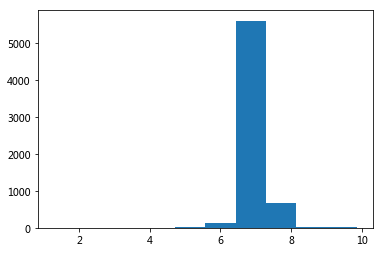

In [327]:
plt.hist(adjust_pred(m_t.predict(valid_sf)))

In [267]:
valid_rmse = []
train_rmse = []

for n in xrange(1, 50):
    m = mf_model(train_sf, num_factors=n)
    valid_rmse.append(np.sqrt(np.mean((np.array(valid_sf['user_rating']) - adjust_pred(m.predict(valid_sf))) ** 2)))
    train_rmse.append(m.training_rmse)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.064432s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 1        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 136us        | NA                     |

+---------+--------------+------------------------+

| 0       | 59.418ms     | 2.02567                |

| 1       | 94.05ms      | 1.70395                |

| 2       | 134.425ms    | 1.646                  |

| 3       | 182.773ms    | 1.61701                |

| 4       | 219.278ms    | 1.59747                |

| 5       | 254.448ms    | 1.58344                |

| 6       | 286.483ms    | 1.57349                |

| 7       | 309.092ms    | 1.56596                |

| 8       | 341.337ms    | 1.55997                |

| 9       | 363.034ms    | 1.55538                |

| 10      | 383.841ms    | 1.55188                |

| 11      | 411.246ms    | 1.54911                |

| 12      | 453.636ms    | 1.54681                |

| 13      | 480.539ms    | 1.54492                |

| 14      | 499.233ms    | 1.54293                |

| 15      | 519.246ms    | 1.54149                |

| 16      | 539.259ms    | 1.54025                |

| 17      | 556.413ms    | 1.53926                |

| 18      | 584.086ms    | 1.53826                |

| 19      | 605.238ms    | 1.53743                |

| 20      | 620.699ms    | 1.53677                |

| 21      | 638.794ms    | 1.53599                |

| 22      | 669.023ms    | 1.53492                |

| 23      | 696.984ms    | 1.53424                |

| 24      | 711.473ms    | 1.5337                 |

| 25      | 723.96ms     | 1.53331                |

| 26      | 745.72ms     | 1.53297                |

| 27      | 762.561ms    | 1.53269                |

| 28      | 787.044ms    | 1.53242                |

| 29      | 805.643ms    | 1.53215                |

| 30      | 825.104ms    | 1.53174                |

| 31      | 842.015ms    | 1.53133                |

| 32      | 865.049ms    | 1.53113                |

| 33      | 887.935ms    | 1.53098                |

| 34      | 911.607ms    | 1.53085                |

| 35      | 933.032ms    | 1.5307                 |

| 36      | 959.2ms      | 1.53057                |

| 37      | 982.221ms    | 1.53047                |

| 38      | 1.00s        | 1.53036                |

| 39      | 1.02s        | 1.53028                |

| 40      | 1.06s        | 1.5302                 |

| 41      | 1.08s        | 1.53002                |

| 42      | 1.11s        | 1.52979                |

| 43      | 1.12s        | 1.52968                |

| 44      | 1.14s        | 1.52956                |

| 45      | 1.17s        | 1.52943                |

| 46      | 1.19s        | 1.5293                 |

| 47      | 1.21s        | 1.52921                |

| 48      | 1.23s        | 1.52915                |

| 49      | 1.25s        | 1.5291                 |

| FINAL   | 1.25s        | 1.5291                 |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.041077s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 2        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 79us         | NA                     |

+---------+--------------+------------------------+

| 0       | 51.134ms     | 1.9391                 |

| 1       | 69.525ms     | 1.34902                |

| 2       | 95.562ms     | 1.27384                |

| 3       | 117.877ms    | 1.23532                |

| 4       | 142.744ms    | 1.20942                |

| 5       | 161.88ms     | 1.1903                 |

| 6       | 186.846ms    | 1.17551                |

| 7       | 202.148ms    | 1.16431                |

| 8       | 229.75ms     | 1.15502                |

| 9       | 263.275ms    | 1.14696                |

| 10      | 300.418ms    | 1.14009                |

| 11      | 321.441ms    | 1.13418                |

| 12      | 347.793ms    | 1.12909                |

| 13      | 374.578ms    | 1.12408                |

| 14      | 398.189ms    | 1.11977                |

| 15      | 427.509ms    | 1.11635                |

| 16      | 445.356ms    | 1.11333                |

| 17      | 487.553ms    | 1.11058                |

| 18      | 509.469ms    | 1.10803                |

| 19      | 534.241ms    | 1.10595                |

| 20      | 560.366ms    | 1.10412                |

| 21      | 586.055ms    | 1.10256                |

| 22      | 611.18ms     | 1.10124                |

| 23      | 640.361ms    | 1.09997                |

| 24      | 665.52ms     | 1.09869                |

| 25      | 691.307ms    | 1.09768                |

| 26      | 715.124ms    | 1.09674                |

| 27      | 734.647ms    | 1.09571                |

| 28      | 762.575ms    | 1.09481                |

| 29      | 786.56ms     | 1.09407                |

| 30      | 802.317ms    | 1.09328                |

| 31      | 829.563ms    | 1.09255                |

| 32      | 853.537ms    | 1.09177                |

| 33      | 868.479ms    | 1.09096                |

| 34      | 892.694ms    | 1.09037                |

| 35      | 916.94ms     | 1.08986                |

| 36      | 934.86ms     | 1.08939                |

| 37      | 952.895ms    | 1.08893                |

| 38      | 978.009ms    | 1.08845                |

| 39      | 995.797ms    | 1.08794                |

| 40      | 1.02s        | 1.08743                |

| 41      | 1.04s        | 1.0869                 |

| 42      | 1.05s        | 1.08628                |

| 43      | 1.08s        | 1.08564                |

| 44      | 1.10s        | 1.08513                |

| 45      | 1.13s        | 1.08468                |

| 46      | 1.15s        | 1.08425                |

| 47      | 1.17s        | 1.0838                 |

| 48      | 1.19s        | 1.08332                |

| 49      | 1.23s        | 1.08285                |

| FINAL   | 1.23s        | 1.08285                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.035087s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 3        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 61us         | NA                     |

+---------+--------------+------------------------+

| 0       | 28.87ms      | 1.92912                |

| 1       | 39.476ms     | 1.13133                |

| 2       | 54.697ms     | 1.04046                |

| 3       | 82.458ms     | 0.993645               |

| 4       | 101.225ms    | 0.960112               |

| 5       | 124.067ms    | 0.934542               |

| 6       | 143.676ms    | 0.915458               |

| 7       | 162.409ms    | 0.900201               |

| 8       | 183.315ms    | 0.887486               |

| 9       | 201.735ms    | 0.876461               |

| 10      | 225.37ms     | 0.866062               |

| 11      | 244.575ms    | 0.857069               |

| 12      | 256.772ms    | 0.849165               |

| 13      | 276.818ms    | 0.842372               |

| 14      | 296.945ms    | 0.836396               |

| 15      | 325.049ms    | 0.830874               |

| 16      | 345.045ms    | 0.825797               |

| 17      | 368.685ms    | 0.820955               |

| 18      | 389.028ms    | 0.816017               |

| 19      | 415.54ms     | 0.811408               |

| 20      | 454.395ms    | 0.807128               |

| 21      | 483.425ms    | 0.803623               |

| 22      | 506.226ms    | 0.800471               |

| 23      | 528.864ms    | 0.797458               |

| 24      | 554.666ms    | 0.794878               |

| 25      | 573.521ms    | 0.79251                |

| 26      | 598.516ms    | 0.790252               |

| 27      | 624.993ms    | 0.78792                |

| 28      | 644.279ms    | 0.785639               |

| 29      | 669.733ms    | 0.783474               |

| 30      | 685.607ms    | 0.781508               |

| 31      | 699.613ms    | 0.779639               |

| 32      | 713.713ms    | 0.777983               |

| 33      | 726.916ms    | 0.776559               |

| 34      | 743.176ms    | 0.775197               |

| 35      | 767.556ms    | 0.773875               |

| 36      | 788.335ms    | 0.772502               |

| 37      | 816.88ms     | 0.77134                |

| 38      | 845.512ms    | 0.770284               |

| 39      | 863.682ms    | 0.769262               |

| 40      | 889.746ms    | 0.768238               |

| 41      | 906.655ms    | 0.767213               |

| 42      | 921.173ms    | 0.76621                |

| 43      | 976.35ms     | 0.765215               |

| 44      | 995.914ms    | 0.764095               |

| 45      | 1.01s        | 0.763059               |

| 46      | 1.03s        | 0.762101               |

| 47      | 1.06s        | 0.761084               |

| 48      | 1.08s        | 0.760033               |

| 49      | 1.11s        | 0.759024               |

| FINAL   | 1.11s        | 0.759024               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.038824s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 4        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 61us         | NA                     |

+---------+--------------+------------------------+

| 0       | 43.709ms     | 1.88303                |

| 1       | 67.953ms     | 0.943313               |

| 2       | 93.83ms      | 0.850045               |

| 3       | 122.065ms    | 0.796627               |

| 4       | 140.736ms    | 0.760522               |

| 5       | 211.828ms    | 0.733101               |

| 6       | 235.12ms     | 0.711056               |

| 7       | 257.979ms    | 0.692168               |

| 8       | 288.151ms    | 0.675852               |

| 9       | 315.724ms    | 0.662322               |

| 10      | 339.374ms    | 0.650881               |

| 11      | 365.735ms    | 0.641005               |

| 12      | 392.626ms    | 0.632292               |

| 13      | 419.024ms    | 0.62438                |

| 14      | 441.01ms     | 0.617012               |

| 15      | 476.913ms    | 0.609722               |

| 16      | 507.864ms    | 0.603044               |

| 17      | 524.597ms    | 0.596879               |

| 18      | 556.54ms     | 0.590867               |

| 19      | 587.945ms    | 0.585035               |

| 20      | 614.907ms    | 0.579445               |

| 21      | 650.116ms    | 0.574228               |

| 22      | 675.242ms    | 0.569607               |

| 23      | 702.004ms    | 0.565453               |

| 24      | 719.72ms     | 0.561631               |

| 25      | 742.162ms    | 0.558035               |

| 26      | 768.649ms    | 0.554623               |

| 27      | 792.615ms    | 0.551536               |

| 28      | 817.867ms    | 0.548744               |

| 29      | 835.997ms    | 0.546225               |

| 30      | 858.831ms    | 0.54393                |

| 31      | 880.435ms    | 0.541803               |

| 32      | 896.395ms    | 0.539769               |

| 33      | 918.365ms    | 0.537758               |

| 34      | 932.023ms    | 0.535794               |

| 35      | 955.104ms    | 0.534098               |

| 36      | 983.494ms    | 0.532544               |

| 37      | 1.00s        | 0.531089               |

| 38      | 1.03s        | 0.529706               |

| 39      | 1.05s        | 0.528326               |

| 40      | 1.08s        | 0.526942               |

| 41      | 1.12s        | 0.525655               |

| 42      | 1.14s        | 0.52443                |

| 43      | 1.17s        | 0.523236               |

| 44      | 1.19s        | 0.522044               |

| 45      | 1.21s        | 0.52082                |

| 46      | 1.23s        | 0.51956                |

| 47      | 1.25s        | 0.518286               |

| 48      | 1.28s        | 0.516962               |

| 49      | 1.30s        | 0.515585               |

| FINAL   | 1.30s        | 0.515585               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.086326s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 5        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 66us         | NA                     |

+---------+--------------+------------------------+

| 0       | 30.562ms     | 1.89348                |

| 1       | 63.206ms     | 0.788885               |

| 2       | 86.346ms     | 0.693017               |

| 3       | 106.719ms    | 0.639962               |

| 4       | 127.985ms    | 0.601585               |

| 5       | 148.274ms    | 0.570691               |

| 6       | 160.893ms    | 0.54464                |

| 7       | 198.215ms    | 0.522423               |

| 8       | 226.465ms    | 0.503222               |

| 9       | 246.344ms    | 0.486459               |

| 10      | 286.461ms    | 0.47159                |

| 11      | 314.152ms    | 0.458438               |

| 12      | 348.371ms    | 0.446811               |

| 13      | 365.714ms    | 0.436484               |

| 14      | 388.721ms    | 0.427238               |

| 15      | 414.991ms    | 0.418866               |

| 16      | 440.175ms    | 0.411231               |

| 17      | 466.924ms    | 0.404144               |

| 18      | 492.086ms    | 0.397549               |

| 19      | 512.912ms    | 0.391459               |

| 20      | 540.201ms    | 0.38581                |

| 21      | 562.997ms    | 0.380577               |

| 22      | 582.687ms    | 0.375731               |

| 23      | 602.234ms    | 0.371264               |

| 24      | 621.267ms    | 0.367158               |

| 25      | 639.283ms    | 0.363371               |

| 26      | 663.83ms     | 0.359866               |

| 27      | 687.376ms    | 0.356608               |

| 28      | 715.611ms    | 0.353563               |

| 29      | 747.907ms    | 0.350708               |

| 30      | 766.597ms    | 0.348038               |

| 31      | 792.406ms    | 0.345505               |

| 32      | 813.67ms     | 0.343078               |

| 33      | 838.718ms    | 0.340783               |

| 34      | 869.848ms    | 0.338596               |

| 35      | 890.909ms    | 0.336509               |

| 36      | 919.676ms    | 0.334499               |

| 37      | 941.411ms    | 0.332627               |

| 38      | 970.606ms    | 0.330914               |

| 39      | 994.806ms    | 0.329332               |

| 40      | 1.02s        | 0.32786                |

| 41      | 1.05s        | 0.32648                |

| 42      | 1.07s        | 0.325171               |

| 43      | 1.09s        | 0.32392                |

| 44      | 1.11s        | 0.322719               |

| 45      | 1.13s        | 0.321574               |

| 46      | 1.15s        | 0.320491               |

| 47      | 1.18s        | 0.319464               |

| 48      | 1.20s        | 0.318484               |

| 49      | 1.23s        | 0.317544               |

| FINAL   | 1.23s        | 0.317544               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.045337s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 6        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 72us         | NA                     |

+---------+--------------+------------------------+

| 0       | 26.745ms     | 1.85823                |

| 1       | 47.179ms     | 0.686024               |

| 2       | 68.487ms     | 0.581986               |

| 3       | 89.682ms     | 0.524639               |

| 4       | 108.193ms    | 0.484642               |

| 5       | 130.725ms    | 0.454275               |

| 6       | 149.889ms    | 0.429581               |

| 7       | 170.234ms    | 0.408271               |

| 8       | 187.617ms    | 0.389462               |

| 9       | 211.538ms    | 0.373103               |

| 10      | 238.509ms    | 0.359164               |

| 11      | 265.124ms    | 0.34699                |

| 12      | 292.808ms    | 0.336193               |

| 13      | 311.069ms    | 0.326506               |

| 14      | 331.918ms    | 0.31771                |

| 15      | 351.029ms    | 0.309442               |

| 16      | 375.849ms    | 0.301812               |

| 17      | 394.299ms    | 0.295058               |

| 18      | 417.531ms    | 0.288924               |

| 19      | 435.488ms    | 0.283278               |

| 20      | 461.231ms    | 0.278001               |

| 21      | 491.357ms    | 0.273039               |

| 22      | 518.869ms    | 0.268399               |

| 23      | 546.382ms    | 0.264058               |

| 24      | 568.487ms    | 0.259985               |

| 25      | 594.348ms    | 0.256154               |

| 26      | 615.206ms    | 0.25254                |

| 27      | 643.458ms    | 0.249093               |

| 28      | 672.362ms    | 0.245777               |

| 29      | 693.594ms    | 0.242595               |

| 30      | 717.068ms    | 0.239587               |

| 31      | 739.807ms    | 0.236746               |

| 32      | 771.152ms    | 0.233995               |

| 33      | 794.02ms     | 0.231157               |

| 34      | 820.47ms     | 0.22847                |

| 35      | 839.377ms    | 0.225962               |

| 36      | 865.641ms    | 0.22354                |

| 37      | 886.368ms    | 0.221188               |

| 38      | 909.01ms     | 0.218893               |

| 39      | 961.261ms    | 0.216694               |

| 40      | 990.949ms    | 0.214577               |

| 41      | 1.03s        | 0.212536               |

| 42      | 1.05s        | 0.210576               |

| 43      | 1.08s        | 0.208683               |

| 44      | 1.11s        | 0.206839               |

| 45      | 1.12s        | 0.205027               |

| 46      | 1.15s        | 0.203226               |

| 47      | 1.17s        | 0.201451               |

| 48      | 1.20s        | 0.199771               |

| 49      | 1.23s        | 0.198186               |

| FINAL   | 1.23s        | 0.198186               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.045703s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 7        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 131us        | NA                     |

+---------+--------------+------------------------+

| 0       | 30.175ms     | 1.85142                |

| 1       | 52.412ms     | 0.598896               |

| 2       | 74.457ms     | 0.495901               |

| 3       | 97.758ms     | 0.437562               |

| 4       | 123.157ms    | 0.395723               |

| 5       | 151.888ms    | 0.362501               |

| 6       | 174.97ms     | 0.334487               |

| 7       | 195.146ms    | 0.310183               |

| 8       | 218.291ms    | 0.289161               |

| 9       | 239.994ms    | 0.270748               |

| 10      | 266.846ms    | 0.25468                |

| 11      | 286.104ms    | 0.240868               |

| 12      | 310.671ms    | 0.228905               |

| 13      | 338.329ms    | 0.218419               |

| 14      | 359.022ms    | 0.209185               |

| 15      | 387.023ms    | 0.200975               |

| 16      | 411.811ms    | 0.193603               |

| 17      | 426.377ms    | 0.186934               |

| 18      | 447.944ms    | 0.180857               |

| 19      | 481.939ms    | 0.175277               |

| 20      | 504.598ms    | 0.170139               |

| 21      | 531.125ms    | 0.165387               |

| 22      | 556.064ms    | 0.160977               |

| 23      | 582.623ms    | 0.156885               |

| 24      | 611.877ms    | 0.153087               |

| 25      | 630.542ms    | 0.149553               |

| 26      | 652.769ms    | 0.14625                |

| 27      | 675.385ms    | 0.143159               |

| 28      | 698.79ms     | 0.140271               |

| 29      | 719.208ms    | 0.137564               |

| 30      | 743.082ms    | 0.135013               |

| 31      | 773.76ms     | 0.132609               |

| 32      | 805.681ms    | 0.13035                |

| 33      | 834.608ms    | 0.128224               |

| 34      | 867.756ms    | 0.12622                |

| 35      | 900.188ms    | 0.124325               |

| 36      | 925.034ms    | 0.122532               |

| 37      | 943.36ms     | 0.120831               |

| 38      | 966.769ms    | 0.119216               |

| 39      | 989.507ms    | 0.117678               |

| 40      | 1.00s        | 0.116212               |

| 41      | 1.02s        | 0.114811               |

| 42      | 1.04s        | 0.11347                |

| 43      | 1.07s        | 0.112183               |

| 44      | 1.09s        | 0.110947               |

| 45      | 1.11s        | 0.109756               |

| 46      | 1.14s        | 0.108607               |

| 47      | 1.17s        | 0.107495               |

| 48      | 1.19s        | 0.106416               |

| 49      | 1.21s        | 0.105366               |

| FINAL   | 1.21s        | 0.105366               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032991s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 63us         | NA                     |

+---------+--------------+------------------------+

| 0       | 32.93ms      | 1.81733                |

| 1       | 52.024ms     | 0.52491                |

| 2       | 81.804ms     | 0.417548               |

| 3       | 105.578ms    | 0.358931               |

| 4       | 139.193ms    | 0.317343               |

| 5       | 164.766ms    | 0.28576                |

| 6       | 200.176ms    | 0.260197               |

| 7       | 223.762ms    | 0.238805               |

| 8       | 238.29ms     | 0.220517               |

| 9       | 263.64ms     | 0.204703               |

| 10      | 284.825ms    | 0.190913               |

| 11      | 308.131ms    | 0.178774               |

| 12      | 333.578ms    | 0.167991               |

| 13      | 353.411ms    | 0.158429               |

| 14      | 377.256ms    | 0.149981               |

| 15      | 404.357ms    | 0.142479               |

| 16      | 428.848ms    | 0.135741               |

| 17      | 453.186ms    | 0.129622               |

| 18      | 478.233ms    | 0.124017               |

| 19      | 501.362ms    | 0.118881               |

| 20      | 521.137ms    | 0.114172               |

| 21      | 542.917ms    | 0.109848               |

| 22      | 563.236ms    | 0.105874               |

| 23      | 589.273ms    | 0.102214               |

| 24      | 613.481ms    | 0.0988414              |

| 25      | 632.567ms    | 0.0957302              |

| 26      | 660.996ms    | 0.0928601              |

| 27      | 683.007ms    | 0.0902126              |

| 28      | 704.744ms    | 0.0877683              |

| 29      | 729.579ms    | 0.0855022              |

| 30      | 756.34ms     | 0.0834066              |

| 31      | 780.676ms    | 0.0814737              |

| 32      | 834.447ms    | 0.0796864              |

| 33      | 867.269ms    | 0.0780311              |

| 34      | 928.337ms    | 0.0764972              |

| 35      | 963.312ms    | 0.0750732              |

| 36      | 994.746ms    | 0.0737485              |

| 37      | 1.03s        | 0.0725138              |

| 38      | 1.05s        | 0.0713607              |

| 39      | 1.08s        | 0.0702816              |

| 40      | 1.11s        | 0.0692698              |

| 41      | 1.14s        | 0.0683193              |

| 42      | 1.16s        | 0.0674248              |

| 43      | 1.19s        | 0.0665817              |

| 44      | 1.26s        | 0.0657859              |

| 45      | 1.29s        | 0.0650336              |

| 46      | 1.32s        | 0.0643218              |

| 47      | 1.35s        | 0.0636472              |

| 48      | 1.37s        | 0.0630073              |

| 49      | 1.41s        | 0.0623994              |

| FINAL   | 1.41s        | 0.0623994              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.033603s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 9        |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 64us         | NA                     |

+---------+--------------+------------------------+

| 0       | 34.326ms     | 1.82773                |

| 1       | 70.003ms     | 0.460273               |

| 2       | 93.108ms     | 0.353653               |

| 3       | 121.402ms    | 0.297061               |

| 4       | 142.743ms    | 0.257191               |

| 5       | 168.814ms    | 0.227524               |

| 6       | 193.08ms     | 0.204279               |

| 7       | 230.028ms    | 0.18515                |

| 8       | 255.771ms    | 0.168972               |

| 9       | 283.664ms    | 0.155054               |

| 10      | 310.188ms    | 0.142946               |

| 11      | 331.804ms    | 0.132411               |

| 12      | 363.147ms    | 0.123277               |

| 13      | 388.586ms    | 0.11537                |

| 14      | 412.5ms      | 0.108492               |

| 15      | 436.359ms    | 0.102451               |

| 16      | 462.369ms    | 0.0970954              |

| 17      | 485.254ms    | 0.0923116              |

| 18      | 515.651ms    | 0.0880154              |

| 19      | 541.465ms    | 0.0841421              |

| 20      | 574.389ms    | 0.0806412              |

| 21      | 602.281ms    | 0.0774736              |

| 22      | 630.209ms    | 0.0746082              |

| 23      | 656.512ms    | 0.072015               |

| 24      | 680.371ms    | 0.0696654              |

| 25      | 713.288ms    | 0.0675342              |

| 26      | 749.67ms     | 0.065599               |

| 27      | 775.352ms    | 0.06384                |

| 28      | 803.19ms     | 0.0622392              |

| 29      | 829.853ms    | 0.0607803              |

| 30      | 855.126ms    | 0.0594484              |

| 31      | 881.251ms    | 0.0582306              |

| 32      | 908.574ms    | 0.0571154              |

| 33      | 933.412ms    | 0.0560928              |

| 34      | 959.18ms     | 0.055154               |

| 35      | 986.839ms    | 0.0542914              |

| 36      | 1.01s        | 0.0534979              |

| 37      | 1.04s        | 0.0527673              |

| 38      | 1.07s        | 0.0520937              |

| 39      | 1.09s        | 0.0514719              |

| 40      | 1.13s        | 0.050897               |

| 41      | 1.15s        | 0.0503646              |

| 42      | 1.18s        | 0.0498708              |

| 43      | 1.22s        | 0.0494121              |

| 44      | 1.25s        | 0.0489852              |

| 45      | 1.27s        | 0.0485874              |

| 46      | 1.31s        | 0.0482161              |

| 47      | 1.33s        | 0.0478689              |

| 48      | 1.36s        | 0.0475438              |

| 49      | 1.40s        | 0.0472389              |

| FINAL   | 1.40s        | 0.0472389              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034986s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 63us         | NA                     |

+---------+--------------+------------------------+

| 0       | 32.149ms     | 1.83036                |

| 1       | 59.141ms     | 0.422821               |

| 2       | 94.36ms      | 0.318603               |

| 3       | 126.553ms    | 0.261622               |

| 4       | 154.223ms    | 0.222235               |

| 5       | 195.761ms    | 0.192946               |

| 6       | 224.877ms    | 0.170277               |

| 7       | 258.25ms     | 0.152322               |

| 8       | 281.482ms    | 0.137694               |

| 9       | 307.69ms     | 0.125477               |

| 10      | 334.209ms    | 0.115195               |

| 11      | 360.864ms    | 0.106533               |

| 12      | 387.769ms    | 0.0992192              |

| 13      | 420.601ms    | 0.0930107              |

| 14      | 447.715ms    | 0.0876991              |

| 15      | 475.562ms    | 0.0831105              |

| 16      | 501.98ms     | 0.0791067              |

| 17      | 529.745ms    | 0.0755825              |

| 18      | 567.366ms    | 0.0724594              |

| 19      | 594.687ms    | 0.0696776              |

| 20      | 622.342ms    | 0.0671904              |

| 21      | 649.282ms    | 0.06496                |

| 22      | 676.998ms    | 0.0629546              |

| 23      | 718.636ms    | 0.0611469              |

| 24      | 766.728ms    | 0.0595133              |

| 25      | 808.266ms    | 0.0580341              |

| 26      | 834.826ms    | 0.0566927              |

| 27      | 863.619ms    | 0.0554749              |

| 28      | 890.681ms    | 0.0543683              |

| 29      | 915.937ms    | 0.0533619              |

| 30      | 946.218ms    | 0.0524461              |

| 31      | 970.055ms    | 0.051612               |

| 32      | 996.746ms    | 0.0508514              |

| 33      | 1.02s        | 0.0501568              |

| 34      | 1.05s        | 0.0495213              |

| 35      | 1.07s        | 0.0489387              |

| 36      | 1.09s        | 0.0484034              |

| 37      | 1.12s        | 0.0479105              |

| 38      | 1.15s        | 0.0474556              |

| 39      | 1.17s        | 0.0470346              |

| 40      | 1.20s        | 0.0466443              |

| 41      | 1.23s        | 0.0462817              |

| 42      | 1.26s        | 0.0459441              |

| 43      | 1.28s        | 0.0456293              |

| 44      | 1.31s        | 0.0453353              |

| 45      | 1.34s        | 0.0450602              |

| 46      | 1.37s        | 0.0448024              |

| 47      | 1.39s        | 0.0445605              |

| 48      | 1.43s        | 0.0443332              |

| 49      | 1.46s        | 0.0441191              |

| FINAL   | 1.46s        | 0.0441191              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.034904s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 11       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 74us         | NA                     |

+---------+--------------+------------------------+

| 0       | 35.502ms     | 1.83399                |

| 1       | 66.604ms     | 0.373693               |

| 2       | 94.233ms     | 0.27343                |

| 3       | 125.055ms    | 0.222341               |

| 4       | 155.632ms    | 0.188081               |

| 5       | 182.885ms    | 0.163045               |

| 6       | 213.037ms    | 0.14382                |

| 7       | 241.626ms    | 0.128594               |

| 8       | 272.644ms    | 0.11627                |

| 9       | 298.826ms    | 0.106166               |

| 10      | 354.211ms    | 0.0978036              |

| 11      | 385.675ms    | 0.0908081              |

| 12      | 415.692ms    | 0.0848997              |

| 13      | 453.598ms    | 0.0798737              |

| 14      | 482.602ms    | 0.0755717              |

| 15      | 513.409ms    | 0.0718656              |

| 16      | 541.822ms    | 0.0686532              |

| 17      | 581.554ms    | 0.065853               |

| 18      | 620.033ms    | 0.0633989              |

| 19      | 649.51ms     | 0.0612374              |

| 20      | 676.446ms    | 0.0593247              |

| 21      | 705.075ms    | 0.0576254              |

| 22      | 732.73ms     | 0.0561104              |

| 23      | 772.969ms    | 0.0547551              |

| 24      | 804.306ms    | 0.0535387              |

| 25      | 834.047ms    | 0.0524436              |

| 26      | 864.552ms    | 0.0514547              |

| 27      | 894.779ms    | 0.0505596              |

| 28      | 924.934ms    | 0.0497477              |

| 29      | 954.133ms    | 0.0490098              |

| 30      | 982.773ms    | 0.0483378              |

| 31      | 1.02s        | 0.0477244              |

| 32      | 1.05s        | 0.0471636              |

| 33      | 1.10s        | 0.0466497              |

| 34      | 1.14s        | 0.0461782              |

| 35      | 1.17s        | 0.0457448              |

| 36      | 1.20s        | 0.045346               |

| 37      | 1.25s        | 0.0449782              |

| 38      | 1.28s        | 0.0446384              |

| 39      | 1.30s        | 0.044324               |

| 40      | 1.34s        | 0.0440326              |

| 41      | 1.37s        | 0.0437618              |

| 42      | 1.40s        | 0.0435098              |

| 43      | 1.43s        | 0.0432748              |

| 44      | 1.46s        | 0.0430555              |

| 45      | 1.49s        | 0.0428504              |

| 46      | 1.52s        | 0.0426583              |

| 47      | 1.55s        | 0.0424781              |

| 48      | 1.58s        | 0.0423088              |

| 49      | 1.60s        | 0.0421495              |

| FINAL   | 1.60s        | 0.0421495              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027032s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 12       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 64us         | NA                     |

+---------+--------------+------------------------+

| 0       | 38.912ms     | 1.85519                |

| 1       | 64.647ms     | 0.332264               |

| 2       | 93.401ms     | 0.23512                |

| 3       | 125.1ms      | 0.189113               |

| 4       | 152.495ms    | 0.159098               |

| 5       | 180.059ms    | 0.137178               |

| 6       | 234.519ms    | 0.120433               |

| 7       | 276.353ms    | 0.107195               |

| 8       | 306.764ms    | 0.0965171              |

| 9       | 338.347ms    | 0.0878329              |

| 10      | 365.997ms    | 0.0807716              |

| 11      | 395.111ms    | 0.0750441              |

| 12      | 423.463ms    | 0.0703977              |

| 13      | 454.149ms    | 0.0666098              |

| 14      | 482.459ms    | 0.0634919              |

| 15      | 524.743ms    | 0.0608935              |

| 16      | 557.419ms    | 0.0587                 |

| 17      | 585.904ms    | 0.0568254              |

| 18      | 614.001ms    | 0.0552054              |

| 19      | 644.879ms    | 0.0537919              |

| 20      | 675.305ms    | 0.0525483              |

| 21      | 706.766ms    | 0.0514466              |

| 22      | 729.19ms     | 0.0504649              |

| 23      | 759.426ms    | 0.0495856              |

| 24      | 789.988ms    | 0.0487949              |

| 25      | 820.947ms    | 0.0480811              |

| 26      | 847.805ms    | 0.0474344              |

| 27      | 876.68ms     | 0.0468469              |

| 28      | 904.029ms    | 0.0463114              |

| 29      | 934.532ms    | 0.045822               |

| 30      | 971.165ms    | 0.0453735              |

| 31      | 1.00s        | 0.0449613              |

| 32      | 1.03s        | 0.0445814              |

| 33      | 1.08s        | 0.0442304              |

| 34      | 1.11s        | 0.0439053              |

| 35      | 1.17s        | 0.0436036              |

| 36      | 1.20s        | 0.0433231              |

| 37      | 1.23s        | 0.0430617              |

| 38      | 1.25s        | 0.0428177              |

| 39      | 1.29s        | 0.0425896              |

| 40      | 1.32s        | 0.0423759              |

| 41      | 1.35s        | 0.0421754              |

| 42      | 1.38s        | 0.0419869              |

| 43      | 1.41s        | 0.0418095              |

| 44      | 1.44s        | 0.0416423              |

| 45      | 1.52s        | 0.0414846              |

| 46      | 1.55s        | 0.0413356              |

| 47      | 1.59s        | 0.0411948              |

| 48      | 1.63s        | 0.0410615              |

| 49      | 1.67s        | 0.0409353              |

| FINAL   | 1.67s        | 0.0409353              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.046372s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 13       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 84us         | NA                     |

+---------+--------------+------------------------+

| 0       | 75.066ms     | 1.86952                |

| 1       | 121.478ms    | 0.301118               |

| 2       | 151.248ms    | 0.208842               |

| 3       | 185.967ms    | 0.165038               |

| 4       | 220.612ms    | 0.137904               |

| 5       | 254.944ms    | 0.119584               |

| 6       | 287.668ms    | 0.106385               |

| 7       | 320.719ms    | 0.0963933              |

| 8       | 351.507ms    | 0.0885025              |

| 9       | 384.408ms    | 0.0820548              |

| 10      | 425.72ms     | 0.0766639              |

| 11      | 464.405ms    | 0.0720944              |

| 12      | 497.002ms    | 0.0681925              |

| 13      | 539.309ms    | 0.0648507              |

| 14      | 573.019ms    | 0.0619871              |

| 15      | 607.336ms    | 0.059534               |

| 16      | 641ms        | 0.0574304              |

| 17      | 671.02ms     | 0.0556213              |

| 18      | 704.011ms    | 0.0540582              |

| 19      | 739.393ms    | 0.0527                 |

| 20      | 768.772ms    | 0.0515118              |

| 21      | 799.802ms    | 0.0504655              |

| 22      | 832.905ms    | 0.0495377              |

| 23      | 863.569ms    | 0.0487101              |

| 24      | 899.756ms    | 0.0479674              |

| 25      | 931.201ms    | 0.0472976              |

| 26      | 964.336ms    | 0.0466908              |

| 27      | 997.246ms    | 0.0461387              |

| 28      | 1.02s        | 0.0456348              |

| 29      | 1.05s        | 0.0451731              |

| 30      | 1.09s        | 0.044749               |

| 31      | 1.12s        | 0.0443581              |

| 32      | 1.15s        | 0.0439971              |

| 33      | 1.18s        | 0.0436629              |

| 34      | 1.21s        | 0.0433529              |

| 35      | 1.24s        | 0.0430646              |

| 36      | 1.30s        | 0.0427961              |

| 37      | 1.33s        | 0.0425454              |

| 38      | 1.37s        | 0.0423112              |

| 39      | 1.41s        | 0.0420918              |

| 40      | 1.44s        | 0.0418862              |

| 41      | 1.53s        | 0.0416931              |

| 42      | 1.56s        | 0.0415116              |

| 43      | 1.60s        | 0.0413407              |

| 44      | 1.64s        | 0.0411797              |

| 45      | 1.68s        | 0.0410278              |

| 46      | 1.72s        | 0.0408843              |

| 47      | 1.75s        | 0.0407487              |

| 48      | 1.79s        | 0.0406203              |

| 49      | 1.83s        | 0.0404988              |

| FINAL   | 1.83s        | 0.0404988              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02828s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 14       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 61us         | NA                     |

+---------+--------------+------------------------+

| 0       | 43.496ms     | 1.87199                |

| 1       | 74.675ms     | 0.272891               |

| 2       | 109.461ms    | 0.185918               |

| 3       | 139.916ms    | 0.147006               |

| 4       | 175.881ms    | 0.122431               |

| 5       | 205.968ms    | 0.105669               |

| 6       | 241.426ms    | 0.0937891              |

| 7       | 293.708ms    | 0.0850265              |

| 8       | 329.227ms    | 0.0783345              |

| 9       | 361.278ms    | 0.0730785              |

| 10      | 396.304ms    | 0.0688561              |

| 11      | 429.353ms    | 0.0653998              |

| 12      | 470.966ms    | 0.0625241              |

| 13      | 505.529ms    | 0.0600961              |

| 14      | 539.016ms    | 0.0580203              |

| 15      | 575.195ms    | 0.0562265              |

| 16      | 606.867ms    | 0.0546622              |

| 17      | 638.984ms    | 0.0532874              |

| 18      | 672.852ms    | 0.0520709              |

| 19      | 717.027ms    | 0.0509878              |

| 20      | 749.898ms    | 0.0500182              |

| 21      | 785.072ms    | 0.049146               |

| 22      | 817.842ms    | 0.0483578              |

| 23      | 851.664ms    | 0.0476429              |

| 24      | 882.787ms    | 0.0469921              |

| 25      | 915.832ms    | 0.0463978              |

| 26      | 952.717ms    | 0.0458535              |

| 27      | 983.265ms    | 0.0453537              |

| 28      | 1.01s        | 0.0448937              |

| 29      | 1.05s        | 0.0444694              |

| 30      | 1.08s        | 0.0440775              |

| 31      | 1.11s        | 0.0437147              |

| 32      | 1.14s        | 0.0433782              |

| 33      | 1.18s        | 0.0430656              |

| 34      | 1.23s        | 0.0427747              |

| 35      | 1.27s        | 0.0425037              |

| 36      | 1.30s        | 0.0422507              |

| 37      | 1.33s        | 0.0420142              |

| 38      | 1.36s        | 0.041793               |

| 39      | 1.40s        | 0.0415858              |

| 40      | 1.43s        | 0.0413915              |

| 41      | 1.46s        | 0.0412091              |

| 42      | 1.49s        | 0.0410378              |

| 43      | 1.53s        | 0.0408766              |

| 44      | 1.59s        | 0.0407249              |

| 45      | 1.63s        | 0.0405818              |

| 46      | 1.66s        | 0.0404469              |

| 47      | 1.69s        | 0.0403194              |

| 48      | 1.73s        | 0.0401989              |

| 49      | 1.76s        | 0.0400849              |

| FINAL   | 1.76s        | 0.0400849              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024805s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 15       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 66us         | NA                     |

+---------+--------------+------------------------+

| 0       | 42.231ms     | 1.88175                |

| 1       | 79.493ms     | 0.250657               |

| 2       | 112.341ms    | 0.170818               |

| 3       | 147.368ms    | 0.135888               |

| 4       | 184.207ms    | 0.114711               |

| 5       | 219.905ms    | 0.100262               |

| 6       | 254.982ms    | 0.0897914              |

| 7       | 290.161ms    | 0.081907               |

| 8       | 325.908ms    | 0.0758099              |

| 9       | 361.132ms    | 0.0709839              |

| 10      | 412.708ms    | 0.0670772              |

| 11      | 445.92ms     | 0.0638542              |

| 12      | 485.576ms    | 0.0611533              |

| 13      | 518.631ms    | 0.0588598              |

| 14      | 554.312ms    | 0.0568901              |

| 15      | 594.427ms    | 0.0551823              |

| 16      | 628.688ms    | 0.0536894              |

| 17      | 665.756ms    | 0.0523753              |

| 18      | 701.553ms    | 0.051211               |

| 19      | 749.398ms    | 0.0501735              |

| 20      | 780.554ms    | 0.049244               |

| 21      | 815.212ms    | 0.0484075              |

| 22      | 863.31ms     | 0.0476515              |

| 23      | 910.319ms    | 0.0469655              |

| 24      | 952.425ms    | 0.046341               |

| 25      | 986.331ms    | 0.0457709              |

| 26      | 1.02s        | 0.0452494              |

| 27      | 1.07s        | 0.0447713              |

| 28      | 1.15s        | 0.044332               |

| 29      | 1.20s        | 0.0439273              |

| 30      | 1.23s        | 0.043554               |

| 31      | 1.27s        | 0.0432087              |

| 32      | 1.33s        | 0.0428889              |

| 33      | 1.37s        | 0.0425921              |

| 34      | 1.41s        | 0.0423163              |

| 35      | 1.49s        | 0.0420595              |

| 36      | 1.52s        | 0.0418201              |

| 37      | 1.56s        | 0.0415965              |

| 38      | 1.60s        | 0.0413874              |

| 39      | 1.65s        | 0.0411917              |

| 40      | 1.69s        | 0.0410082              |

| 41      | 1.72s        | 0.040836               |

| 42      | 1.76s        | 0.0406742              |

| 43      | 1.80s        | 0.040522               |

| 44      | 1.83s        | 0.0403787              |

| 45      | 1.89s        | 0.0402437              |

| 46      | 1.93s        | 0.0401163              |

| 47      | 1.97s        | 0.039996               |

| 48      | 2.01s        | 0.0398823              |

| 49      | 2.05s        | 0.0397748              |

| FINAL   | 2.05s        | 0.0397748              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03894s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 16       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 67us         | NA                     |

+---------+--------------+------------------------+

| 0       | 36.937ms     | 1.88758                |

| 1       | 70.257ms     | 0.235645               |

| 2       | 103.633ms    | 0.161864               |

| 3       | 135.496ms    | 0.129653               |

| 4       | 170.907ms    | 0.109819               |

| 5       | 199.965ms    | 0.0962136              |

| 6       | 235.742ms    | 0.0863891              |

| 7       | 272.865ms    | 0.0790118              |

| 8       | 315.256ms    | 0.0733007              |

| 9       | 349.056ms    | 0.0687705              |

| 10      | 382.736ms    | 0.0651021              |

| 11      | 414.55ms     | 0.0620771              |

| 12      | 446.222ms    | 0.0595431              |

| 13      | 479.899ms    | 0.0573928              |

| 14      | 514.229ms    | 0.055548               |

| 15      | 549.321ms    | 0.0539502              |

| 16      | 597.112ms    | 0.0525547              |

| 17      | 626.838ms    | 0.0513269              |

| 18      | 666.612ms    | 0.0502408              |

| 19      | 701.056ms    | 0.0492754              |

| 20      | 733.374ms    | 0.048413               |

| 21      | 766.123ms    | 0.0476388              |

| 22      | 800.477ms    | 0.0469407              |

| 23      | 834.78ms     | 0.0463086              |

| 24      | 868.415ms    | 0.0457343              |

| 25      | 902.306ms    | 0.0452109              |

| 26      | 946.225ms    | 0.0447323              |

| 27      | 979.578ms    | 0.0442934              |

| 28      | 1.01s        | 0.0438899              |

| 29      | 1.04s        | 0.0435181              |

| 30      | 1.08s        | 0.0431746              |

| 31      | 1.11s        | 0.0428567              |

| 32      | 1.15s        | 0.0425618              |

| 33      | 1.18s        | 0.0422879              |

| 34      | 1.21s        | 0.0420329              |

| 35      | 1.24s        | 0.0417952              |

| 36      | 1.28s        | 0.0415732              |

| 37      | 1.31s        | 0.0413656              |

| 38      | 1.35s        | 0.0411712              |

| 39      | 1.38s        | 0.0409888              |

| 40      | 1.43s        | 0.0408176              |

| 41      | 1.46s        | 0.0406566              |

| 42      | 1.52s        | 0.040505               |

| 43      | 1.56s        | 0.0403623              |

| 44      | 1.60s        | 0.0402276              |

| 45      | 1.63s        | 0.0401006              |

| 46      | 1.67s        | 0.0399806              |

| 47      | 1.70s        | 0.0398672              |

| 48      | 1.74s        | 0.03976                |

| 49      | 1.77s        | 0.0396585              |

| FINAL   | 1.77s        | 0.0396585              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029201s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 17       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 80us         | NA                     |

+---------+--------------+------------------------+

| 0       | 40.938ms     | 1.89434                |

| 1       | 78.194ms     | 0.232771               |

| 2       | 113.414ms    | 0.156949               |

| 3       | 156.873ms    | 0.124831               |

| 4       | 195.907ms    | 0.106003               |

| 5       | 233.786ms    | 0.0933618              |

| 6       | 272.435ms    | 0.0842705              |

| 7       | 309.743ms    | 0.0774306              |

| 8       | 347.139ms    | 0.0721145              |

| 9       | 389.41ms     | 0.0678726              |

| 10      | 425.706ms    | 0.0644126              |

| 11      | 463.819ms    | 0.061539               |

| 12      | 504.992ms    | 0.0591172              |

| 13      | 542.227ms    | 0.0570513              |

| 14      | 589.015ms    | 0.0552706              |

| 15      | 627.267ms    | 0.0537223              |

| 16      | 665.106ms    | 0.0523658              |

| 17      | 713.114ms    | 0.0511692              |

| 18      | 751.313ms    | 0.0501071              |

| 19      | 791.943ms    | 0.049159               |

| 20      | 830.591ms    | 0.0483082              |

| 21      | 867.206ms    | 0.0475411              |

| 22      | 904.391ms    | 0.0468467              |

| 23      | 952.649ms    | 0.0462161              |

| 24      | 992.216ms    | 0.0456416              |

| 25      | 1.02s        | 0.0451171              |

| 26      | 1.06s        | 0.0446368              |

| 27      | 1.10s        | 0.0441961              |

| 28      | 1.14s        | 0.0437907              |

| 29      | 1.17s        | 0.0434169              |

| 30      | 1.22s        | 0.0430715              |

| 31      | 1.25s        | 0.0427518              |

| 32      | 1.29s        | 0.0424552              |

| 33      | 1.33s        | 0.0421795              |

| 34      | 1.36s        | 0.0419229              |

| 35      | 1.40s        | 0.0416836              |

| 36      | 1.44s        | 0.0414601              |

| 37      | 1.48s        | 0.041251               |

| 38      | 1.51s        | 0.0410553              |

| 39      | 1.55s        | 0.0408718              |

| 40      | 1.59s        | 0.0406996              |

| 41      | 1.63s        | 0.0405378              |

| 42      | 1.67s        | 0.0403856              |

| 43      | 1.71s        | 0.0402423              |

| 44      | 1.75s        | 0.0401073              |

| 45      | 1.79s        | 0.03998                |

| 46      | 1.83s        | 0.0398597              |

| 47      | 1.88s        | 0.0397461              |

| 48      | 1.92s        | 0.0396386              |

| 49      | 1.96s        | 0.0395368              |

| FINAL   | 1.96s        | 0.0395368              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.035072s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 18       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 60us         | NA                     |

+---------+--------------+------------------------+

| 0       | 39.076ms     | 1.89646                |

| 1       | 76.422ms     | 0.225888               |

| 2       | 115.572ms    | 0.154278               |

| 3       | 156.912ms    | 0.122985               |

| 4       | 194.351ms    | 0.104541               |

| 5       | 233.192ms    | 0.0922106              |

| 6       | 272.032ms    | 0.083315               |

| 7       | 312.232ms    | 0.0765772              |

| 8       | 353.944ms    | 0.0713018              |

| 9       | 400.367ms    | 0.0670718              |

| 10      | 438.104ms    | 0.0636186              |

| 11      | 476.847ms    | 0.0607583              |

| 12      | 516.082ms    | 0.0583588              |

| 13      | 557.325ms    | 0.0563222              |

| 14      | 594.726ms    | 0.0545753              |

| 15      | 634.741ms    | 0.0530629              |

| 16      | 673.167ms    | 0.0517429              |

| 17      | 715.123ms    | 0.0505821              |

| 18      | 751.09ms     | 0.0495545              |

| 19      | 790.344ms    | 0.0486394              |

| 20      | 830.137ms    | 0.0478202              |

| 21      | 874.395ms    | 0.0470832              |

| 22      | 917.082ms    | 0.0464175              |

| 23      | 967.157ms    | 0.0458136              |

| 24      | 1.00s        | 0.045264               |

| 25      | 1.04s        | 0.0447622              |

| 26      | 1.08s        | 0.0443028              |

| 27      | 1.12s        | 0.0438812              |

| 28      | 1.16s        | 0.0434931              |

| 29      | 1.21s        | 0.0431351              |

| 30      | 1.25s        | 0.0428042              |

| 31      | 1.28s        | 0.0424975              |

| 32      | 1.32s        | 0.0422129              |

| 33      | 1.36s        | 0.0419481              |

| 34      | 1.39s        | 0.0417015              |

| 35      | 1.43s        | 0.0414713              |

| 36      | 1.48s        | 0.0412561              |

| 37      | 1.53s        | 0.0410548              |

| 38      | 1.57s        | 0.0408661              |

| 39      | 1.60s        | 0.0406891              |

| 40      | 1.64s        | 0.0405229              |

| 41      | 1.68s        | 0.0403666              |

| 42      | 1.72s        | 0.0402194              |

| 43      | 1.76s        | 0.0400808              |

| 44      | 1.80s        | 0.0399501              |

| 45      | 1.84s        | 0.0398268              |

| 46      | 1.88s        | 0.0397103              |

| 47      | 1.92s        | 0.0396001              |

| 48      | 1.96s        | 0.039496               |

| 49      | 2.00s        | 0.0393973              |

| FINAL   | 2.00s        | 0.0393973              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.033545s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 19       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 63us         | NA                     |

+---------+--------------+------------------------+

| 0       | 47.65ms      | 1.90383                |

| 1       | 86.697ms     | 0.211969               |

| 2       | 130.161ms    | 0.145016               |

| 3       | 171.354ms    | 0.117061               |

| 4       | 211.001ms    | 0.100423               |

| 5       | 253.113ms    | 0.08914                |

| 6       | 293.96ms     | 0.0809096              |

| 7       | 336.376ms    | 0.0746435              |

| 8       | 393.825ms    | 0.0697347              |

| 9       | 433.787ms    | 0.0658003              |

| 10      | 479.84ms     | 0.062584               |

| 11      | 522.482ms    | 0.0599102              |

| 12      | 560.942ms    | 0.0576557              |

| 13      | 605.828ms    | 0.0557317              |

| 14      | 648.014ms    | 0.0540732              |

| 15      | 687.929ms    | 0.0526311              |

| 16      | 732.105ms    | 0.0513676              |

| 17      | 770.715ms    | 0.0502534              |

| 18      | 815.24ms     | 0.0492649              |

| 19      | 860.343ms    | 0.0483832              |

| 20      | 902.443ms    | 0.0475927              |

| 21      | 945.217ms    | 0.0468807              |

| 22      | 988.417ms    | 0.0462369              |

| 23      | 1.03s        | 0.0456524              |

| 24      | 1.07s        | 0.04512                |

| 25      | 1.11s        | 0.0446333              |

| 26      | 1.16s        | 0.0441872              |

| 27      | 1.20s        | 0.0437771              |

| 28      | 1.25s        | 0.0433991              |

| 29      | 1.29s        | 0.0430498              |

| 30      | 1.33s        | 0.0427264              |

| 31      | 1.38s        | 0.0424263              |

| 32      | 1.42s        | 0.0421473              |

| 33      | 1.46s        | 0.0418875              |

| 34      | 1.51s        | 0.0416451              |

| 35      | 1.55s        | 0.0414187              |

| 36      | 1.59s        | 0.041207               |

| 37      | 1.63s        | 0.0410086              |

| 38      | 1.68s        | 0.0408225              |

| 39      | 1.72s        | 0.0406478              |

| 40      | 1.76s        | 0.0404835              |

| 41      | 1.80s        | 0.0403289              |

| 42      | 1.84s        | 0.0401832              |

| 43      | 1.92s        | 0.0400458              |

| 44      | 1.96s        | 0.039916               |

| 45      | 2.00s        | 0.0397933              |

| 46      | 2.04s        | 0.0396773              |

| 47      | 2.09s        | 0.0395675              |

| 48      | 2.13s        | 0.0394634              |

| 49      | 2.18s        | 0.0393647              |

| FINAL   | 2.18s        | 0.0393647              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02538s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 20       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 58us         | NA                     |

+---------+--------------+------------------------+

| 0       | 48.568ms     | 1.91277                |

| 1       | 92.19ms      | 0.207466               |

| 2       | 135.04ms     | 0.143224               |

| 3       | 176.747ms    | 0.115455               |

| 4       | 217.383ms    | 0.0987147              |

| 5       | 259.532ms    | 0.0874128              |

| 6       | 302.369ms    | 0.0792598              |

| 7       | 344.362ms    | 0.0731114              |

| 8       | 388.055ms    | 0.0683273              |

| 9       | 430.343ms    | 0.0645118              |

| 10      | 482.051ms    | 0.0614053              |

| 11      | 519.843ms    | 0.0588316              |

| 12      | 570.463ms    | 0.0566674              |

| 13      | 612.958ms    | 0.0548248              |

| 14      | 655.129ms    | 0.0532395              |

| 15      | 694.651ms    | 0.0518633              |

| 16      | 737.288ms    | 0.050659               |

| 17      | 778.691ms    | 0.0495978              |

| 18      | 822.799ms    | 0.0486565              |

| 19      | 864.407ms    | 0.0478166              |

| 20      | 907.636ms    | 0.0470634              |

| 21      | 958.473ms    | 0.0463848              |

| 22      | 1.00s        | 0.0457709              |

| 23      | 1.04s        | 0.0452135              |

| 24      | 1.09s        | 0.0447057              |

| 25      | 1.13s        | 0.0442416              |

| 26      | 1.17s        | 0.0438163              |

| 27      | 1.22s        | 0.0434254              |

| 28      | 1.26s        | 0.0430653              |

| 29      | 1.31s        | 0.0427327              |

| 30      | 1.35s        | 0.0424249              |

| 31      | 1.39s        | 0.0421395              |

| 32      | 1.43s        | 0.0418743              |

| 33      | 1.47s        | 0.0416276              |

| 34      | 1.51s        | 0.0413976              |

| 35      | 1.56s        | 0.0411828              |

| 36      | 1.60s        | 0.0409821              |

| 37      | 1.65s        | 0.0407942              |

| 38      | 1.70s        | 0.0406181              |

| 39      | 1.75s        | 0.0404528              |

| 40      | 1.79s        | 0.0402976              |

| 41      | 1.84s        | 0.0401515              |

| 42      | 1.89s        | 0.0400141              |

| 43      | 1.95s        | 0.0398846              |

| 44      | 1.99s        | 0.0397624              |

| 45      | 2.03s        | 0.039647               |

| 46      | 2.07s        | 0.039538               |

| 47      | 2.11s        | 0.0394349              |

| 48      | 2.15s        | 0.0393372              |

| 49      | 2.21s        | 0.0392448              |

| FINAL   | 2.21s        | 0.0392448              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027406s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 21       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 61us         | NA                     |

+---------+--------------+------------------------+

| 0       | 51.191ms     | 1.91682                |

| 1       | 99.239ms     | 0.197565               |

| 2       | 143.024ms    | 0.137653               |

| 3       | 188.47ms     | 0.111439               |

| 4       | 234.848ms    | 0.0958295              |

| 5       | 282.794ms    | 0.0852801              |

| 6       | 326.774ms    | 0.0776299              |

| 7       | 370.406ms    | 0.0718262              |

| 8       | 416.674ms    | 0.0672781              |

| 9       | 459.739ms    | 0.0636242              |

| 10      | 506.188ms    | 0.0606313              |

| 11      | 552.595ms    | 0.0581419              |

| 12      | 603.255ms    | 0.0560451              |

| 13      | 654.598ms    | 0.0542594              |

| 14      | 698.579ms    | 0.0527239              |

| 15      | 742.571ms    | 0.0513922              |

| 16      | 794.941ms    | 0.0502282              |

| 17      | 866.871ms    | 0.0492033              |

| 18      | 918.806ms    | 0.0482948              |

| 19      | 962.458ms    | 0.0474848              |

| 20      | 1.00s        | 0.0467587              |

| 21      | 1.06s        | 0.0461046              |

| 22      | 1.10s        | 0.0455129              |

| 23      | 1.15s        | 0.0449756              |

| 24      | 1.20s        | 0.0444861              |

| 25      | 1.25s        | 0.0440385              |

| 26      | 1.29s        | 0.0436283              |

| 27      | 1.34s        | 0.0432512              |

| 28      | 1.39s        | 0.0429037              |

| 29      | 1.44s        | 0.0425828              |

| 30      | 1.48s        | 0.0422859              |

| 31      | 1.52s        | 0.0420105              |

| 32      | 1.57s        | 0.0417547              |

| 33      | 1.62s        | 0.0415166              |

| 34      | 1.67s        | 0.0412948              |

| 35      | 1.72s        | 0.0410876              |

| 36      | 1.77s        | 0.040894               |

| 37      | 1.82s        | 0.0407127              |

| 38      | 1.86s        | 0.0405428              |

| 39      | 1.91s        | 0.0403833              |

| 40      | 1.96s        | 0.0402335              |

| 41      | 2.01s        | 0.0400925              |

| 42      | 2.05s        | 0.0399597              |

| 43      | 2.10s        | 0.0398344              |

| 44      | 2.14s        | 0.0397163              |

| 45      | 2.19s        | 0.0396046              |

| 46      | 2.24s        | 0.039499               |

| 47      | 2.30s        | 0.0393991              |

| 48      | 2.36s        | 0.0393044              |

| 49      | 2.40s        | 0.0392147              |

| FINAL   | 2.40s        | 0.0392147              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025974s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 22       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 58us         | NA                     |

+---------+--------------+------------------------+

| 0       | 62.894ms     | 1.91859                |

| 1       | 110.227ms    | 0.192638               |

| 2       | 157.474ms    | 0.134402               |

| 3       | 204.463ms    | 0.109414               |

| 4       | 251.968ms    | 0.0943667              |

| 5       | 300.916ms    | 0.0841301              |

| 6       | 346.536ms    | 0.0766759              |

| 7       | 399.225ms    | 0.0710097              |

| 8       | 452.023ms    | 0.0665699              |

| 9       | 506.374ms    | 0.0630107              |

| 10      | 556.353ms    | 0.0601048              |

| 11      | 610.706ms    | 0.0576937              |

| 12      | 663.57ms     | 0.0556636              |

| 13      | 726.712ms    | 0.0539324              |

| 14      | 783.28ms     | 0.0524406              |

| 15      | 828.039ms    | 0.0511436              |

| 16      | 875.065ms    | 0.050007               |

| 17      | 919.628ms    | 0.0490037              |

| 18      | 970.963ms    | 0.0481124              |

| 19      | 1.02s        | 0.0473161              |

| 20      | 1.07s        | 0.0466009              |

| 21      | 1.12s        | 0.0459559              |

| 22      | 1.17s        | 0.0453718              |

| 23      | 1.21s        | 0.044841               |

| 24      | 1.26s        | 0.0443571              |

| 25      | 1.31s        | 0.0439147              |

| 26      | 1.35s        | 0.0435089              |

| 27      | 1.40s        | 0.0431359              |

| 28      | 1.45s        | 0.042792               |

| 29      | 1.50s        | 0.0424744              |

| 30      | 1.54s        | 0.0421803              |

| 31      | 1.59s        | 0.0419076              |

| 32      | 1.63s        | 0.0416542              |

| 33      | 1.68s        | 0.0414183              |

| 34      | 1.73s        | 0.0411985              |

| 35      | 1.78s        | 0.0409933              |

| 36      | 1.82s        | 0.0408016              |

| 37      | 1.87s        | 0.0406223              |

| 38      | 1.92s        | 0.0404542              |

| 39      | 1.97s        | 0.0402966              |

| 40      | 2.01s        | 0.0401486              |

| 41      | 2.06s        | 0.0400095              |

| 42      | 2.11s        | 0.0398786              |

| 43      | 2.15s        | 0.0397554              |

| 44      | 2.20s        | 0.0396391              |

| 45      | 2.25s        | 0.0395293              |

| 46      | 2.30s        | 0.0394256              |

| 47      | 2.35s        | 0.0393275              |

| 48      | 2.40s        | 0.0392347              |

| 49      | 2.47s        | 0.0391467              |

| FINAL   | 2.47s        | 0.0391467              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028352s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 23       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 58us         | NA                     |

+---------+--------------+------------------------+

| 0       | 53.553ms     | 1.91492                |

| 1       | 105.415ms    | 0.198446               |

| 2       | 156.873ms    | 0.13632                |

| 3       | 217.394ms    | 0.109864               |

| 4       | 270.098ms    | 0.0943004              |

| 5       | 320.695ms    | 0.083889               |

| 6       | 372.388ms    | 0.076392               |

| 7       | 421.89ms     | 0.0707279              |

| 8       | 486.877ms    | 0.066303               |

| 9       | 546.13ms     | 0.0627598              |

| 10      | 606.173ms    | 0.0598671              |

| 11      | 658.936ms    | 0.0574673              |

| 12      | 709.6ms      | 0.0554493              |

| 13      | 760.204ms    | 0.0537323              |

| 14      | 815.054ms    | 0.052256               |

| 15      | 866.887ms    | 0.0509744              |

| 16      | 923.077ms    | 0.0498523              |

| 17      | 973.191ms    | 0.0488625              |

| 18      | 1.02s        | 0.0479837              |

| 19      | 1.07s        | 0.047199               |

| 20      | 1.12s        | 0.0464947              |

| 21      | 1.19s        | 0.04586                |

| 22      | 1.25s        | 0.0452855              |

| 23      | 1.31s        | 0.0447636              |

| 24      | 1.37s        | 0.0442878              |

| 25      | 1.43s        | 0.0438527              |

| 26      | 1.52s        | 0.0434537              |

| 27      | 1.58s        | 0.0430867              |

| 28      | 1.64s        | 0.0427484              |

| 29      | 1.73s        | 0.0424358              |

| 30      | 1.78s        | 0.0421463              |

| 31      | 1.84s        | 0.0418777              |

| 32      | 1.90s        | 0.0416281              |

| 33      | 1.96s        | 0.0413957              |

| 34      | 2.03s        | 0.0411789              |

| 35      | 2.09s        | 0.0409764              |

| 36      | 2.14s        | 0.040787               |

| 37      | 2.22s        | 0.0406096              |

| 38      | 2.28s        | 0.0404433              |

| 39      | 2.34s        | 0.040287               |

| 40      | 2.40s        | 0.0401402              |

| 41      | 2.47s        | 0.0400019              |

| 42      | 2.53s        | 0.0398717              |

| 43      | 2.59s        | 0.0397488              |

| 44      | 2.65s        | 0.0396328              |

| 45      | 2.71s        | 0.0395232              |

| 46      | 2.81s        | 0.0394195              |

| 47      | 2.87s        | 0.0393213              |

| 48      | 2.93s        | 0.0392283              |

| 49      | 3.00s        | 0.0391401              |

| FINAL   | 3.00s        | 0.0391401              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03121s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 24       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 81us         | NA                     |

+---------+--------------+------------------------+

| 0       | 60.696ms     | 1.93557                |

| 1       | 126.499ms    | 0.179811               |

| 2       | 187.123ms    | 0.126372               |

| 3       | 256.819ms    | 0.103525               |

| 4       | 344.902ms    | 0.0898407              |

| 5       | 420.268ms    | 0.0805451              |

| 6       | 482.967ms    | 0.0737711              |

| 7       | 539.857ms    | 0.0686068              |

| 8       | 606.659ms    | 0.0645454              |

| 9       | 666.869ms    | 0.0612794              |

| 10      | 737.264ms    | 0.0586056              |

| 11      | 796.762ms    | 0.0563824              |

| 12      | 860.715ms    | 0.0545083              |

| 13      | 919.367ms    | 0.0529099              |

| 14      | 974.764ms    | 0.0515323              |

| 15      | 1.03s        | 0.0503342              |

| 16      | 1.09s        | 0.0492839              |

| 17      | 1.16s        | 0.0483566              |

| 18      | 1.22s        | 0.0475327              |

| 19      | 1.28s        | 0.0467966              |

| 20      | 1.35s        | 0.0461353              |

| 21      | 1.41s        | 0.0455385              |

| 22      | 1.48s        | 0.0449975              |

| 23      | 1.54s        | 0.0445052              |

| 24      | 1.60s        | 0.0440554              |

| 25      | 1.67s        | 0.0436432              |

| 26      | 1.74s        | 0.0432643              |

| 27      | 1.79s        | 0.042915               |

| 28      | 1.85s        | 0.0425922              |

| 29      | 1.90s        | 0.0422932              |

| 30      | 1.96s        | 0.0420157              |

| 31      | 2.01s        | 0.0417576              |

| 32      | 2.06s        | 0.0415173              |

| 33      | 2.10s        | 0.041293               |

| 34      | 2.15s        | 0.0410834              |

| 35      | 2.20s        | 0.0408873              |

| 36      | 2.25s        | 0.0407036              |

| 37      | 2.30s        | 0.0405313              |

| 38      | 2.35s        | 0.0403695              |

| 39      | 2.41s        | 0.0402175              |

| 40      | 2.46s        | 0.0400745              |

| 41      | 2.51s        | 0.0399398              |

| 42      | 2.56s        | 0.0398129              |

| 43      | 2.61s        | 0.0396931              |

| 44      | 2.66s        | 0.0395801              |

| 45      | 2.72s        | 0.0394733              |

| 46      | 2.79s        | 0.0393723              |

| 47      | 2.83s        | 0.0392767              |

| 48      | 2.88s        | 0.0391862              |

| 49      | 2.92s        | 0.0391004              |

| FINAL   | 2.92s        | 0.0391004              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027614s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 25       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 56us         | NA                     |

+---------+--------------+------------------------+

| 0       | 59.479ms     | 1.9451                 |

| 1       | 115.904ms    | 0.172751               |

| 2       | 168.487ms    | 0.120798               |

| 3       | 224.757ms    | 0.0991149              |

| 4       | 283.915ms    | 0.0860886              |

| 5       | 347.762ms    | 0.0772832              |

| 6       | 403.621ms    | 0.0709304              |

| 7       | 457.897ms    | 0.0661361              |

| 8       | 514.421ms    | 0.0623935              |

| 9       | 569.823ms    | 0.0593946              |

| 10      | 625.472ms    | 0.0569416              |

| 11      | 679.384ms    | 0.0549021              |

| 12      | 733.26ms     | 0.0531832              |

| 13      | 788.051ms    | 0.0517173              |

| 14      | 850.525ms    | 0.0504542              |

| 15      | 905.184ms    | 0.0493555              |

| 16      | 960.196ms    | 0.048392               |

| 17      | 1.02s        | 0.0475405              |

| 18      | 1.08s        | 0.046783               |

| 19      | 1.13s        | 0.0461049              |

| 20      | 1.19s        | 0.0454946              |

| 21      | 1.25s        | 0.0449426              |

| 22      | 1.30s        | 0.0444412              |

| 23      | 1.36s        | 0.043984               |

| 24      | 1.41s        | 0.0435656              |

| 25      | 1.47s        | 0.0431816              |

| 26      | 1.53s        | 0.0428282              |

| 27      | 1.58s        | 0.0425022              |

| 28      | 1.64s        | 0.042201               |

| 29      | 1.69s        | 0.041922               |

| 30      | 1.76s        | 0.0416632              |

| 31      | 1.82s        | 0.0414227              |

| 32      | 1.87s        | 0.0411988              |

| 33      | 1.93s        | 0.0409901              |

| 34      | 1.99s        | 0.0407952              |

| 35      | 2.05s        | 0.040613               |

| 36      | 2.11s        | 0.0404425              |

| 37      | 2.17s        | 0.0402827              |

| 38      | 2.26s        | 0.0401327              |

| 39      | 2.33s        | 0.0399918              |

| 40      | 2.38s        | 0.0398594              |

| 41      | 2.44s        | 0.0397347              |

| 42      | 2.50s        | 0.0396172              |

| 43      | 2.57s        | 0.0395064              |

| 44      | 2.63s        | 0.0394018              |

| 45      | 2.69s        | 0.039303               |

| 46      | 2.74s        | 0.0392096              |

| 47      | 2.80s        | 0.0391212              |

| 48      | 2.86s        | 0.0390375              |

| 49      | 2.91s        | 0.0389582              |

| FINAL   | 2.91s        | 0.0389582              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025473s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 26       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 65us         | NA                     |

+---------+--------------+------------------------+

| 0       | 57.686ms     | 1.92912                |

| 1       | 110.451ms    | 0.184374               |

| 2       | 159.117ms    | 0.128151               |

| 3       | 222.607ms    | 0.103961               |

| 4       | 279.135ms    | 0.0895747              |

| 5       | 334.634ms    | 0.0799498              |

| 6       | 387.152ms    | 0.0730326              |

| 7       | 443.071ms    | 0.0678277              |

| 8       | 510.426ms    | 0.0637792              |

| 9       | 575.374ms    | 0.0605464              |

| 10      | 629.943ms    | 0.0579096              |

| 11      | 684.088ms    | 0.0557222              |

| 12      | 738.953ms    | 0.0538828              |

| 13      | 805.766ms    | 0.0523178              |

| 14      | 856.676ms    | 0.0509728              |

| 15      | 931.324ms    | 0.0498061              |

| 16      | 1.05s        | 0.0487859              |

| 17      | 1.12s        | 0.0478873              |

| 18      | 1.17s        | 0.0470904              |

| 19      | 1.24s        | 0.0463794              |

| 20      | 1.30s        | 0.0457416              |

| 21      | 1.37s        | 0.0451665              |

| 22      | 1.42s        | 0.0446456              |

| 23      | 1.49s        | 0.0441719              |

| 24      | 1.55s        | 0.0437396              |

| 25      | 1.61s        | 0.0433436              |

| 26      | 1.67s        | 0.04298                |

| 27      | 1.73s        | 0.0426452              |

| 28      | 1.79s        | 0.0423361              |

| 29      | 1.85s        | 0.0420501              |

| 30      | 1.91s        | 0.041785               |

| 31      | 1.97s        | 0.0415387              |

| 32      | 2.03s        | 0.0413095              |

| 33      | 2.09s        | 0.0410959              |

| 34      | 2.16s        | 0.0408964              |

| 35      | 2.23s        | 0.0407099              |

| 36      | 2.30s        | 0.0405351              |

| 37      | 2.35s        | 0.0403712              |

| 38      | 2.41s        | 0.0402173              |

| 39      | 2.47s        | 0.0400726              |

| 40      | 2.52s        | 0.0399363              |

| 41      | 2.58s        | 0.0398079              |

| 42      | 2.65s        | 0.0396868              |

| 43      | 2.70s        | 0.0395724              |

| 44      | 2.76s        | 0.0394643              |

| 45      | 2.82s        | 0.0393621              |

| 46      | 2.88s        | 0.0392653              |

| 47      | 2.93s        | 0.0391737              |

| 48      | 2.99s        | 0.0390868              |

| 49      | 3.04s        | 0.0390045              |

| FINAL   | 3.04s        | 0.0390045              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024889s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 27       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 85us         | NA                     |

+---------+--------------+------------------------+

| 0       | 75.144ms     | 1.9377                 |

| 1       | 142.837ms    | 0.176864               |

| 2       | 203.098ms    | 0.123534               |

| 3       | 265.306ms    | 0.100761               |

| 4       | 329.897ms    | 0.0871686              |

| 5       | 382.75ms     | 0.0780142              |

| 6       | 443.678ms    | 0.0714137              |

| 7       | 502.977ms    | 0.0664426              |

| 8       | 561.795ms    | 0.0625803              |

| 9       | 633.201ms    | 0.0595055              |

| 10      | 694.589ms    | 0.0570078              |

| 11      | 756.286ms    | 0.0549437              |

| 12      | 818.104ms    | 0.0532119              |

| 13      | 876.228ms    | 0.0517393              |

| 14      | 936.438ms    | 0.0504725              |

| 15      | 1.00s        | 0.0493713              |

| 16      | 1.06s        | 0.0484053              |

| 17      | 1.12s        | 0.0475512              |

| 18      | 1.18s        | 0.0467907              |

| 19      | 1.24s        | 0.0461098              |

| 20      | 1.30s        | 0.045497               |

| 21      | 1.36s        | 0.0449433              |

| 22      | 1.42s        | 0.0444411              |

| 23      | 1.48s        | 0.0439839              |

| 24      | 1.54s        | 0.0435665              |

| 25      | 1.60s        | 0.0431842              |

| 26      | 1.66s        | 0.0428331              |

| 27      | 1.72s        | 0.0425098              |

| 28      | 1.77s        | 0.0422113              |

| 29      | 1.84s        | 0.0419351              |

| 30      | 1.90s        | 0.0416789              |

| 31      | 1.96s        | 0.0414408              |

| 32      | 2.03s        | 0.0412191              |

| 33      | 2.10s        | 0.0410122              |

| 34      | 2.16s        | 0.040819               |

| 35      | 2.22s        | 0.0406382              |

| 36      | 2.28s        | 0.0404687              |

| 37      | 2.34s        | 0.0403097              |

| 38      | 2.40s        | 0.0401602              |

| 39      | 2.46s        | 0.0400197              |

| 40      | 2.52s        | 0.0398872              |

| 41      | 2.58s        | 0.0397624              |

| 42      | 2.64s        | 0.0396446              |

| 43      | 2.69s        | 0.0395332              |

| 44      | 2.76s        | 0.039428               |

| 45      | 2.82s        | 0.0393283              |

| 46      | 2.88s        | 0.039234               |

| 47      | 2.93s        | 0.0391446              |

| 48      | 3.00s        | 0.0390597              |

| 49      | 3.06s        | 0.0389792              |

| FINAL   | 3.06s        | 0.0389792              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026092s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 28       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 57us         | NA                     |

+---------+--------------+------------------------+

| 0       | 66.277ms     | 1.9442                 |

| 1       | 119.486ms    | 0.172948               |

| 2       | 174.787ms    | 0.12212                |

| 3       | 231.674ms    | 0.0999458              |

| 4       | 290.939ms    | 0.0865952              |

| 5       | 359.239ms    | 0.0775729              |

| 6       | 447.032ms    | 0.0710649              |

| 7       | 508.712ms    | 0.0661619              |

| 8       | 566.091ms    | 0.0623453              |

| 9       | 625.798ms    | 0.0592982              |

| 10      | 683.448ms    | 0.0568151              |

| 11      | 743.045ms    | 0.054757               |

| 12      | 813.025ms    | 0.0530272              |

| 13      | 869.747ms    | 0.051556               |

| 14      | 930.174ms    | 0.0502917              |

| 15      | 993.238ms    | 0.0491955              |

| 16      | 1.05s        | 0.0482371              |

| 17      | 1.12s        | 0.0473932              |

| 18      | 1.19s        | 0.0466451              |

| 19      | 1.26s        | 0.0459777              |

| 20      | 1.35s        | 0.0453788              |

| 21      | 1.43s        | 0.0448386              |

| 22      | 1.50s        | 0.0443488              |

| 23      | 1.56s        | 0.043903               |

| 24      | 1.63s        | 0.0434954              |

| 25      | 1.70s        | 0.0431215              |

| 26      | 1.76s        | 0.0427774              |

| 27      | 1.83s        | 0.0424599              |

| 28      | 1.91s        | 0.0421662              |

| 29      | 1.98s        | 0.0418938              |

| 30      | 2.04s        | 0.0416408              |

| 31      | 2.11s        | 0.0414053              |

| 32      | 2.18s        | 0.0411858              |

| 33      | 2.25s        | 0.040981               |

| 34      | 2.33s        | 0.0407896              |

| 35      | 2.41s        | 0.0406106              |

| 36      | 2.50s        | 0.0404429              |

| 37      | 2.59s        | 0.0402856              |

| 38      | 2.69s        | 0.0401379              |

| 39      | 2.77s        | 0.039999               |

| 40      | 2.86s        | 0.0398683              |

| 41      | 2.95s        | 0.0397452              |

| 42      | 3.03s        | 0.039629               |

| 43      | 3.12s        | 0.0395193              |

| 44      | 3.21s        | 0.0394156              |

| 45      | 3.27s        | 0.0393175              |

| 46      | 3.33s        | 0.0392246              |

| 47      | 3.39s        | 0.0391365              |

| 48      | 3.45s        | 0.0390529              |

| 49      | 3.52s        | 0.0389736              |

| FINAL   | 3.52s        | 0.0389736              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.033606s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 29       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 75us         | NA                     |

+---------+--------------+------------------------+

| 0       | 69.927ms     | 1.94212                |

| 1       | 140.644ms    | 0.173999               |

| 2       | 226.222ms    | 0.121689               |

| 3       | 292.014ms    | 0.0996299              |

| 4       | 357.834ms    | 0.0863895              |

| 5       | 425.219ms    | 0.0774543              |

| 6       | 492.423ms    | 0.0710029              |

| 7       | 553.771ms    | 0.0661362              |

| 8       | 625.42ms     | 0.0623443              |

| 9       | 689.181ms    | 0.0593141              |

| 10      | 756.322ms    | 0.0568437              |

| 11      | 821.336ms    | 0.0547968              |

| 12      | 892.465ms    | 0.0530773              |

| 13      | 970.165ms    | 0.0516153              |

| 14      | 1.04s        | 0.0503586              |

| 15      | 1.11s        | 0.0492679              |

| 16      | 1.18s        | 0.0483127              |

| 17      | 1.24s        | 0.0474697              |

| 18      | 1.31s        | 0.0467203              |

| 19      | 1.37s        | 0.04605                |

| 20      | 1.43s        | 0.045447               |

| 21      | 1.50s        | 0.044902               |

| 22      | 1.58s        | 0.0444072              |

| 23      | 1.64s        | 0.0439561              |

| 24      | 1.71s        | 0.0435436              |

| 25      | 1.77s        | 0.0431651              |

| 26      | 1.84s        | 0.0428169              |

| 27      | 1.90s        | 0.0424958              |

| 28      | 1.97s        | 0.0421988              |

| 29      | 2.04s        | 0.0419237              |

| 30      | 2.10s        | 0.0416682              |

| 31      | 2.19s        | 0.0414305              |

| 32      | 2.25s        | 0.041209               |

| 33      | 2.31s        | 0.0410022              |

| 34      | 2.38s        | 0.0408089              |

| 35      | 2.44s        | 0.0406279              |

| 36      | 2.51s        | 0.0404584              |

| 37      | 2.57s        | 0.0402993              |

| 38      | 2.64s        | 0.0401498              |

| 39      | 2.70s        | 0.0400092              |

| 40      | 2.76s        | 0.0398769              |

| 41      | 2.83s        | 0.0397522              |

| 42      | 2.90s        | 0.0396346              |

| 43      | 2.96s        | 0.0395235              |

| 44      | 3.02s        | 0.0394185              |

| 45      | 3.09s        | 0.0393193              |

| 46      | 3.18s        | 0.0392252              |

| 47      | 3.25s        | 0.0391362              |

| 48      | 3.31s        | 0.0390517              |

| 49      | 3.38s        | 0.0389715              |

| FINAL   | 3.38s        | 0.0389715              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027093s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 30       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 58us         | NA                     |

+---------+--------------+------------------------+

| 0       | 71.974ms     | 1.95484                |

| 1       | 139.77ms     | 0.163405               |

| 2       | 202.701ms    | 0.115561               |

| 3       | 273.582ms    | 0.0951379              |

| 4       | 335.387ms    | 0.0829617              |

| 5       | 398.96ms     | 0.0747358              |

| 6       | 466.038ms    | 0.0687954              |

| 7       | 532.79ms     | 0.0643136              |

| 8       | 598.799ms    | 0.0608181              |

| 9       | 674.168ms    | 0.0580198              |

| 10      | 734.439ms    | 0.0557334              |

| 11      | 798.423ms    | 0.0538347              |

| 12      | 862.907ms    | 0.0522363              |

| 13      | 928.21ms     | 0.0508749              |

| 14      | 986.632ms    | 0.0497028              |

| 15      | 1.06s        | 0.0486838              |

| 16      | 1.12s        | 0.0477897              |

| 17      | 1.18s        | 0.046999               |

| 18      | 1.25s        | 0.0462946              |

| 19      | 1.31s        | 0.0456633              |

| 20      | 1.38s        | 0.0450946              |

| 21      | 1.45s        | 0.0445797              |

| 22      | 1.52s        | 0.0441118              |

| 23      | 1.58s        | 0.0436851              |

| 24      | 1.64s        | 0.0432946              |

| 25      | 1.71s        | 0.0429363              |

| 26      | 1.77s        | 0.0426065              |

| 27      | 1.84s        | 0.0423023              |

| 28      | 1.90s        | 0.0420209              |

| 29      | 1.97s        | 0.0417601              |

| 30      | 2.03s        | 0.0415178              |

| 31      | 2.09s        | 0.0412924              |

| 32      | 2.15s        | 0.0410822              |

| 33      | 2.21s        | 0.0408859              |

| 34      | 2.28s        | 0.0407024              |

| 35      | 2.34s        | 0.0405304              |

| 36      | 2.40s        | 0.0403692              |

| 37      | 2.47s        | 0.0402178              |

| 38      | 2.53s        | 0.0400754              |

| 39      | 2.59s        | 0.0399414              |

| 40      | 2.66s        | 0.0398151              |

| 41      | 2.72s        | 0.0396959              |

| 42      | 2.79s        | 0.0395834              |

| 43      | 2.85s        | 0.0394771              |

| 44      | 2.91s        | 0.0393765              |

| 45      | 2.98s        | 0.0392812              |

| 46      | 3.05s        | 0.039191               |

| 47      | 3.10s        | 0.0391055              |

| 48      | 3.17s        | 0.0390243              |

| 49      | 3.23s        | 0.0389472              |

| FINAL   | 3.23s        | 0.0389472              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.030652s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 31       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 54us         | NA                     |

+---------+--------------+------------------------+

| 0       | 88.977ms     | 1.95415                |

| 1       | 153.93ms     | 0.164627               |

| 2       | 236.421ms    | 0.116692               |

| 3       | 319.755ms    | 0.0959264              |

| 4       | 392.55ms     | 0.0835316              |

| 5       | 461.267ms    | 0.0752086              |

| 6       | 532.434ms    | 0.0692058              |

| 7       | 608.029ms    | 0.0646619              |

| 8       | 684.297ms    | 0.0611061              |

| 9       | 757.7ms      | 0.0582558              |

| 10      | 824.97ms     | 0.0559277              |

| 11      | 893.525ms    | 0.0539946              |

| 12      | 965.697ms    | 0.0523666              |

| 13      | 1.03s        | 0.0509793              |

| 14      | 1.10s        | 0.0497849              |

| 15      | 1.17s        | 0.048747               |

| 16      | 1.23s        | 0.0478373              |

| 17      | 1.31s        | 0.0470339              |

| 18      | 1.39s        | 0.0463195              |

| 19      | 1.46s        | 0.0456804              |

| 20      | 1.53s        | 0.0451054              |

| 21      | 1.60s        | 0.0445859              |

| 22      | 1.68s        | 0.0441144              |

| 23      | 1.75s        | 0.043685               |

| 24      | 1.83s        | 0.0432925              |

| 25      | 1.90s        | 0.0429326              |

| 26      | 1.97s        | 0.0426017              |

| 27      | 2.06s        | 0.0422966              |

| 28      | 2.14s        | 0.0420147              |

| 29      | 2.21s        | 0.0417535              |

| 30      | 2.31s        | 0.041511               |

| 31      | 2.39s        | 0.0412854              |

| 32      | 2.48s        | 0.0410752              |

| 33      | 2.57s        | 0.0408789              |

| 34      | 2.64s        | 0.0406953              |

| 35      | 2.71s        | 0.0405234              |

| 36      | 2.78s        | 0.0403622              |

| 37      | 2.86s        | 0.0402107              |

| 38      | 2.93s        | 0.0400682              |

| 39      | 3.01s        | 0.039934               |

| 40      | 3.09s        | 0.0398075              |

| 41      | 3.17s        | 0.039688               |

| 42      | 3.25s        | 0.0395752              |

| 43      | 3.33s        | 0.0394684              |

| 44      | 3.40s        | 0.0393674              |

| 45      | 3.47s        | 0.0392717              |

| 46      | 3.54s        | 0.0391809              |

| 47      | 3.61s        | 0.0390948              |

| 48      | 3.69s        | 0.0390132              |

| 49      | 3.76s        | 0.0389356              |

| FINAL   | 3.76s        | 0.0389356              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027672s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 32       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 72us         | NA                     |

+---------+--------------+------------------------+

| 0       | 76.414ms     | 1.95795                |

| 1       | 145.236ms    | 0.160564               |

| 2       | 226.999ms    | 0.113546               |

| 3       | 293.626ms    | 0.0935411              |

| 4       | 385.834ms    | 0.0815154              |

| 5       | 454.661ms    | 0.0734392              |

| 6       | 523.737ms    | 0.0676465              |

| 7       | 594.908ms    | 0.0632991              |

| 8       | 667.68ms     | 0.059925               |

| 9       | 738.829ms    | 0.0572358              |

| 10      | 810.892ms    | 0.0550457              |

| 11      | 880.414ms    | 0.0532299              |

| 12      | 961.824ms    | 0.0517017              |

| 13      | 1.02s        | 0.0503992              |

| 14      | 1.09s        | 0.0492767              |

| 15      | 1.16s        | 0.0483                 |

| 16      | 1.23s        | 0.0474429              |

| 17      | 1.30s        | 0.0466848              |

| 18      | 1.38s        | 0.0460096              |

| 19      | 1.45s        | 0.0454043              |

| 20      | 1.52s        | 0.0448585              |

| 21      | 1.59s        | 0.0443641              |

| 22      | 1.67s        | 0.0439143              |

| 23      | 1.74s        | 0.0435035              |

| 24      | 1.80s        | 0.0431272              |

| 25      | 1.87s        | 0.0427813              |

| 26      | 1.95s        | 0.0424625              |

| 27      | 2.03s        | 0.042168               |

| 28      | 2.09s        | 0.0418952              |

| 29      | 2.19s        | 0.0416421              |

| 30      | 2.26s        | 0.0414068              |

| 31      | 2.34s        | 0.0411875              |

| 32      | 2.42s        | 0.040983               |

| 33      | 2.49s        | 0.0407918              |

| 34      | 2.56s        | 0.040613               |

| 35      | 2.64s        | 0.0404453              |

| 36      | 2.71s        | 0.0402881              |

| 37      | 2.79s        | 0.0401403              |

| 38      | 2.89s        | 0.0400013              |

| 39      | 2.96s        | 0.0398705              |

| 40      | 3.03s        | 0.0397471              |

| 41      | 3.10s        | 0.0396307              |

| 42      | 3.17s        | 0.0395207              |

| 43      | 3.24s        | 0.0394167              |

| 44      | 3.31s        | 0.0393182              |

| 45      | 3.40s        | 0.0392249              |

| 46      | 3.47s        | 0.0391365              |

| 47      | 3.54s        | 0.0390525              |

| 48      | 3.61s        | 0.0389728              |

| 49      | 3.68s        | 0.038897               |

| FINAL   | 3.68s        | 0.038897               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024694s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 33       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 59us         | NA                     |

+---------+--------------+------------------------+

| 0       | 82.415ms     | 1.95465                |

| 1       | 163.176ms    | 0.166056               |

| 2       | 243.887ms    | 0.115473               |

| 3       | 319.878ms    | 0.0944282              |

| 4       | 396.179ms    | 0.082087               |

| 5       | 471.993ms    | 0.0738263              |

| 6       | 563.076ms    | 0.0678842              |

| 7       | 644.64ms     | 0.0634134              |

| 8       | 723.405ms    | 0.0599436              |

| 9       | 801.031ms    | 0.0571875              |

| 10      | 879.994ms    | 0.0549543              |

| 11      | 957.405ms    | 0.0531129              |

| 12      | 1.03s        | 0.0515707              |

| 13      | 1.11s        | 0.0502613              |

| 14      | 1.19s        | 0.0491363              |

| 15      | 1.27s        | 0.0481594              |

| 16      | 1.35s        | 0.0473031              |

| 17      | 1.43s        | 0.0465463              |

| 18      | 1.51s        | 0.0458727              |

| 19      | 1.60s        | 0.0452695              |

| 20      | 1.68s        | 0.0447265              |

| 21      | 1.76s        | 0.0442354              |

| 22      | 1.84s        | 0.0437894              |

| 23      | 1.92s        | 0.043383               |

| 24      | 1.99s        | 0.0430113              |

| 25      | 2.07s        | 0.0426704              |

| 26      | 2.15s        | 0.0423568              |

| 27      | 2.22s        | 0.0420676              |

| 28      | 2.30s        | 0.0418003              |

| 29      | 2.43s        | 0.0415526              |

| 30      | 2.51s        | 0.0413227              |

| 31      | 2.59s        | 0.0411087              |

| 32      | 2.67s        | 0.0409091              |

| 33      | 2.75s        | 0.0407228              |

| 34      | 2.83s        | 0.0405484              |

| 35      | 2.91s        | 0.0403849              |

| 36      | 2.99s        | 0.0402314              |

| 37      | 3.07s        | 0.0400871              |

| 38      | 3.16s        | 0.0399512              |

| 39      | 3.25s        | 0.0398231              |

| 40      | 3.32s        | 0.0397022              |

| 41      | 3.41s        | 0.0395879              |

| 42      | 3.48s        | 0.0394799              |

| 43      | 3.57s        | 0.0393777              |

| 44      | 3.65s        | 0.0392809              |

| 45      | 3.73s        | 0.0391892              |

| 46      | 3.81s        | 0.0391021              |

| 47      | 3.88s        | 0.0390195              |

| 48      | 3.96s        | 0.038941               |

| 49      | 4.04s        | 0.0388664              |

| FINAL   | 4.04s        | 0.0388664              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028223s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 34       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 85us         | NA                     |

+---------+--------------+------------------------+

| 0       | 87.554ms     | 1.97102                |

| 1       | 166.23ms     | 0.152066               |

| 2       | 259.107ms    | 0.107449               |

| 3       | 353.765ms    | 0.088967               |

| 4       | 459.11ms     | 0.0782204              |

| 5       | 549.568ms    | 0.0709597              |

| 6       | 651.583ms    | 0.0657021              |

| 7       | 746.702ms    | 0.0617188              |

| 8       | 827.517ms    | 0.0586029              |

| 9       | 913.52ms     | 0.0561049              |

| 10      | 995.564ms    | 0.054062               |

| 11      | 1.07s        | 0.0523639              |

| 12      | 1.15s        | 0.0509331              |

| 13      | 1.24s        | 0.0497129              |

| 14      | 1.33s        | 0.0486614              |

| 15      | 1.41s        | 0.0477462              |

| 16      | 1.49s        | 0.0469426              |

| 17      | 1.57s        | 0.0462313              |

| 18      | 1.65s        | 0.0455974              |

| 19      | 1.74s        | 0.0450289              |

| 20      | 1.82s        | 0.044516               |

| 21      | 1.90s        | 0.0440512              |

| 22      | 1.99s        | 0.0436279              |

| 23      | 2.07s        | 0.0432409              |

| 24      | 2.15s        | 0.0428857              |

| 25      | 2.24s        | 0.0425587              |

| 26      | 2.32s        | 0.0422569              |

| 27      | 2.40s        | 0.0419774              |

| 28      | 2.49s        | 0.0417182              |

| 29      | 2.58s        | 0.0414773              |

| 30      | 2.66s        | 0.041253               |

| 31      | 2.74s        | 0.0410437              |

| 32      | 2.83s        | 0.0408482              |

| 33      | 2.92s        | 0.0406653              |

| 34      | 3.01s        | 0.040494               |

| 35      | 3.08s        | 0.0403332              |

| 36      | 3.16s        | 0.0401823              |

| 37      | 3.23s        | 0.0400404              |

| 38      | 3.35s        | 0.0399068              |

| 39      | 3.45s        | 0.0397809              |

| 40      | 3.55s        | 0.0396621              |

| 41      | 3.63s        | 0.03955                |

| 42      | 3.71s        | 0.0394439              |

| 43      | 3.79s        | 0.0393436              |

| 44      | 3.86s        | 0.0392485              |

| 45      | 3.94s        | 0.0391584              |

| 46      | 4.02s        | 0.0390729              |

| 47      | 4.10s        | 0.0389917              |

| 48      | 4.17s        | 0.0389145              |

| 49      | 4.26s        | 0.0388412              |

| FINAL   | 4.26s        | 0.0388412              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02734s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 35       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 88us         | NA                     |

+---------+--------------+------------------------+

| 0       | 89.305ms     | 1.96597                |

| 1       | 171.619ms    | 0.155522               |

| 2       | 257.104ms    | 0.109364               |

| 3       | 342.575ms    | 0.0900797              |

| 4       | 427.763ms    | 0.0787694              |

| 5       | 508.152ms    | 0.071247               |

| 6       | 589.317ms    | 0.0658541              |

| 7       | 680.962ms    | 0.0617962              |

| 8       | 767.927ms    | 0.0586363              |

| 9       | 849.903ms    | 0.0561106              |

| 10      | 934.275ms    | 0.0540499              |

| 11      | 1.02s        | 0.0523402              |

| 12      | 1.11s        | 0.0509012              |

| 13      | 1.19s        | 0.0496749              |

| 14      | 1.27s        | 0.0486184              |

| 15      | 1.36s        | 0.0476994              |

| 16      | 1.45s        | 0.0468932              |

| 17      | 1.54s        | 0.0461805              |

| 18      | 1.62s        | 0.0455461              |

| 19      | 1.71s        | 0.0449778              |

| 20      | 1.80s        | 0.0444658              |

| 21      | 1.88s        | 0.0440022              |

| 22      | 1.97s        | 0.0435805              |

| 23      | 2.07s        | 0.0431953              |

| 24      | 2.16s        | 0.0428422              |

| 25      | 2.24s        | 0.0425174              |

| 26      | 2.33s        | 0.0422178              |

| 27      | 2.41s        | 0.0419407              |

| 28      | 2.50s        | 0.0416837              |

| 29      | 2.58s        | 0.041445               |

| 30      | 2.67s        | 0.0412228              |

| 31      | 2.75s        | 0.0410155              |

| 32      | 2.84s        | 0.0408219              |

| 33      | 2.93s        | 0.0406408              |

| 34      | 3.02s        | 0.0404711              |

| 35      | 3.11s        | 0.0403119              |

| 36      | 3.19s        | 0.0401624              |

| 37      | 3.28s        | 0.0400219              |

| 38      | 3.37s        | 0.0398896              |

| 39      | 3.45s        | 0.0397649              |

| 40      | 3.56s        | 0.0396473              |

| 41      | 3.65s        | 0.0395363              |

| 42      | 3.73s        | 0.0394313              |

| 43      | 3.82s        | 0.039332               |

| 44      | 3.91s        | 0.0392379              |

| 45      | 4.03s        | 0.0391488              |

| 46      | 4.12s        | 0.0390642              |

| 47      | 4.20s        | 0.0389839              |

| 48      | 4.29s        | 0.0389076              |

| 49      | 4.37s        | 0.0388351              |

| FINAL   | 4.37s        | 0.0388351              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.048434s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 36       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 71us         | NA                     |

+---------+--------------+------------------------+

| 0       | 88.516ms     | 1.96956                |

| 1       | 171.534ms    | 0.154069               |

| 2       | 249.687ms    | 0.107418               |

| 3       | 325.632ms    | 0.0882818              |

| 4       | 403.579ms    | 0.077161               |

| 5       | 487.684ms    | 0.0698118              |

| 6       | 566.332ms    | 0.0645717              |

| 7       | 644.659ms    | 0.0606459              |

| 8       | 727.864ms    | 0.0575987              |

| 9       | 807.951ms    | 0.0551695              |

| 10      | 885.111ms    | 0.0531945              |

| 11      | 961.919ms    | 0.0515628              |

| 12      | 1.04s        | 0.0501949              |

| 13      | 1.12s        | 0.0490331              |

| 14      | 1.20s        | 0.0480352              |

| 15      | 1.28s        | 0.0471693              |

| 16      | 1.36s        | 0.0464109              |

| 17      | 1.45s        | 0.045741               |

| 18      | 1.53s        | 0.0451447              |

| 19      | 1.62s        | 0.0446104              |

| 20      | 1.71s        | 0.0441287              |

| 21      | 1.79s        | 0.0436922              |

| 22      | 1.88s        | 0.0432948              |

| 23      | 1.97s        | 0.0429316              |

| 24      | 2.05s        | 0.0425984              |

| 25      | 2.15s        | 0.0422918              |

| 26      | 2.23s        | 0.0420088              |

| 27      | 2.31s        | 0.0417471              |

| 28      | 2.38s        | 0.0415043              |

| 29      | 2.48s        | 0.0412787              |

| 30      | 2.57s        | 0.0410685              |

| 31      | 2.67s        | 0.0408724              |

| 32      | 2.77s        | 0.0406891              |

| 33      | 2.87s        | 0.0405174              |

| 34      | 2.95s        | 0.0403565              |

| 35      | 3.04s        | 0.0402054              |

| 36      | 3.12s        | 0.0400632              |

| 37      | 3.20s        | 0.0399294              |

| 38      | 3.29s        | 0.0398033              |

| 39      | 3.37s        | 0.0396842              |

| 40      | 3.46s        | 0.0395718              |

| 41      | 3.54s        | 0.0394654              |

| 42      | 3.62s        | 0.0393647              |

| 43      | 3.70s        | 0.0392694              |

| 44      | 3.78s        | 0.039179               |

| 45      | 3.86s        | 0.0390932              |

| 46      | 3.94s        | 0.0390117              |

| 47      | 4.03s        | 0.0389343              |

| 48      | 4.11s        | 0.0388607              |

| 49      | 4.23s        | 0.0387907              |

| FINAL   | 4.23s        | 0.0387907              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032176s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 37       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 58us         | NA                     |

+---------+--------------+------------------------+

| 0       | 106.293ms    | 1.9742                 |

| 1       | 198.097ms    | 0.147196               |

| 2       | 291.986ms    | 0.104686               |

| 3       | 384.363ms    | 0.0870414              |

| 4       | 497.452ms    | 0.0766009              |

| 5       | 597.65ms     | 0.0695818              |

| 6       | 685.283ms    | 0.0645189              |

| 7       | 782.901ms    | 0.0606919              |

| 8       | 870.056ms    | 0.057702               |

| 9       | 961.108ms    | 0.0553078              |

| 10      | 1.05s        | 0.0533533              |

| 11      | 1.15s        | 0.051732               |

| 12      | 1.24s        | 0.0503684              |

| 13      | 1.33s        | 0.0492074              |

| 14      | 1.42s        | 0.0482078              |

| 15      | 1.52s        | 0.0473385              |

| 16      | 1.62s        | 0.0465758              |

| 17      | 1.71s        | 0.0459012              |

| 18      | 1.80s        | 0.0453002              |

| 19      | 1.89s        | 0.0447615              |

| 20      | 1.98s        | 0.0442759              |

| 21      | 2.10s        | 0.0438358              |

| 22      | 2.19s        | 0.0434352              |

| 23      | 2.28s        | 0.043069               |

| 24      | 2.37s        | 0.042733               |

| 25      | 2.46s        | 0.0424237              |

| 26      | 2.54s        | 0.0421379              |

| 27      | 2.64s        | 0.0418733              |

| 28      | 2.73s        | 0.0416277              |

| 29      | 2.82s        | 0.0413991              |

| 30      | 2.90s        | 0.0411859              |

| 31      | 2.99s        | 0.0409868              |

| 32      | 3.08s        | 0.0408005              |

| 33      | 3.17s        | 0.0406258              |

| 34      | 3.26s        | 0.0404619              |

| 35      | 3.35s        | 0.0403078              |

| 36      | 3.44s        | 0.0401628              |

| 37      | 3.54s        | 0.0400263              |

| 38      | 3.63s        | 0.0398975              |

| 39      | 3.72s        | 0.0397761              |

| 40      | 3.81s        | 0.0396613              |

| 41      | 3.90s        | 0.0395528              |

| 42      | 3.99s        | 0.0394501              |

| 43      | 4.09s        | 0.0393527              |

| 44      | 4.18s        | 0.0392604              |

| 45      | 4.30s        | 0.0391728              |

| 46      | 4.38s        | 0.0390896              |

| 47      | 4.48s        | 0.0390104              |

| 48      | 4.57s        | 0.0389351              |

| 49      | 4.66s        | 0.0388634              |

| FINAL   | 4.66s        | 0.0388634              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024345s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 38       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 57us         | NA                     |

+---------+--------------+------------------------+

| 0       | 90.383ms     | 1.96949                |

| 1       | 176.18ms     | 0.152259               |

| 2       | 268.698ms    | 0.10686                |

| 3       | 363.997ms    | 0.0880895              |

| 4       | 481.36ms     | 0.0771313              |

| 5       | 588.626ms    | 0.0698465              |

| 6       | 678.466ms    | 0.0646361              |

| 7       | 769.813ms    | 0.0607234              |

| 8       | 866.372ms    | 0.0576802              |

| 9       | 962.038ms    | 0.0552511              |

| 10      | 1.07s        | 0.0532735              |

| 11      | 1.16s        | 0.0516374              |

| 12      | 1.25s        | 0.0502648              |

| 13      | 1.36s        | 0.0490989              |

| 14      | 1.45s        | 0.0480974              |

| 15      | 1.54s        | 0.0472279              |

| 16      | 1.64s        | 0.0464659              |

| 17      | 1.75s        | 0.0457925              |

| 18      | 1.85s        | 0.0451928              |

| 19      | 1.94s        | 0.0446555              |

| 20      | 2.03s        | 0.0441711              |

| 21      | 2.12s        | 0.0437324              |

| 22      | 2.21s        | 0.0433331              |

| 23      | 2.31s        | 0.0429682              |

| 24      | 2.42s        | 0.0426335              |

| 25      | 2.51s        | 0.0423254              |

| 26      | 2.61s        | 0.042041               |

| 27      | 2.72s        | 0.0417777              |

| 28      | 2.84s        | 0.0415334              |

| 29      | 2.93s        | 0.0413062              |

| 30      | 3.02s        | 0.0410945              |

| 31      | 3.12s        | 0.0408969              |

| 32      | 3.20s        | 0.0407122              |

| 33      | 3.30s        | 0.0405393              |

| 34      | 3.39s        | 0.0403771              |

| 35      | 3.48s        | 0.0402249              |

| 36      | 3.57s        | 0.0400818              |

| 37      | 3.66s        | 0.0399471              |

| 38      | 3.76s        | 0.0398201              |

| 39      | 3.85s        | 0.0397004              |

| 40      | 3.96s        | 0.0395873              |

| 41      | 4.06s        | 0.0394804              |

| 42      | 4.15s        | 0.0393793              |

| 43      | 4.24s        | 0.0392836              |

| 44      | 4.33s        | 0.0391929              |

| 45      | 4.42s        | 0.0391068              |

| 46      | 4.51s        | 0.0390252              |

| 47      | 4.60s        | 0.0389476              |

| 48      | 4.69s        | 0.0388739              |

| 49      | 4.79s        | 0.0388037              |

| FINAL   | 4.79s        | 0.0388037              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.037327s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 39       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 78us         | NA                     |

+---------+--------------+------------------------+

| 0       | 103.307ms    | 1.97592                |

| 1       | 202.87ms     | 0.146899               |

| 2       | 303.899ms    | 0.101965               |

| 3       | 410.629ms    | 0.0843009              |

| 4       | 508.291ms    | 0.0740515              |

| 5       | 613.558ms    | 0.0672793              |

| 6       | 714.221ms    | 0.0624773              |

| 7       | 809.594ms    | 0.0588995              |

| 8       | 913.812ms    | 0.0561314              |

| 9       | 1.00s        | 0.0539275              |

| 10      | 1.11s        | 0.0521341              |

| 11      | 1.21s        | 0.0506492              |

| 12      | 1.32s        | 0.0494014              |

| 13      | 1.43s        | 0.0483391              |

| 14      | 1.53s        | 0.0474244              |

| 15      | 1.63s        | 0.0466285              |

| 16      | 1.74s        | 0.0459296              |

| 17      | 1.84s        | 0.0453107              |

| 18      | 1.94s        | 0.0447587              |

| 19      | 2.04s        | 0.0442634              |

| 20      | 2.16s        | 0.0438165              |

| 21      | 2.28s        | 0.043411               |

| 22      | 2.39s        | 0.0430416              |

| 23      | 2.49s        | 0.0427035              |

| 24      | 2.59s        | 0.0423929              |

| 25      | 2.69s        | 0.0421066              |

| 26      | 2.80s        | 0.0418419              |

| 27      | 2.91s        | 0.0415964              |

| 28      | 3.01s        | 0.0413681              |

| 29      | 3.11s        | 0.0411554              |

| 30      | 3.20s        | 0.0409568              |

| 31      | 3.30s        | 0.0407711              |

| 32      | 3.42s        | 0.040597               |

| 33      | 3.53s        | 0.0404335              |

| 34      | 3.64s        | 0.0402799              |

| 35      | 3.74s        | 0.0401354              |

| 36      | 3.84s        | 0.0399991              |

| 37      | 3.95s        | 0.0398705              |

| 38      | 4.06s        | 0.0397491              |

| 39      | 4.17s        | 0.0396342              |

| 40      | 4.27s        | 0.0395255              |

| 41      | 4.36s        | 0.0394225              |

| 42      | 4.47s        | 0.0393248              |

| 43      | 4.57s        | 0.0392321              |

| 44      | 4.67s        | 0.0391441              |

| 45      | 4.77s        | 0.0390604              |

| 46      | 4.88s        | 0.0389809              |

| 47      | 4.98s        | 0.0389053              |

| 48      | 5.08s        | 0.0388334              |

| 49      | 5.18s        | 0.0387648              |

| FINAL   | 5.18s        | 0.0387648              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025525s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 40       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 74us         | NA                     |

+---------+--------------+------------------------+

| 0       | 105.623ms    | 1.97309                |

| 1       | 198.104ms    | 0.148681               |

| 2       | 294.714ms    | 0.105006               |

| 3       | 410.119ms    | 0.0869395              |

| 4       | 511.002ms    | 0.0763362              |

| 5       | 620.554ms    | 0.0692742              |

| 6       | 713.857ms    | 0.0642249              |

| 7       | 804.471ms    | 0.0604396              |

| 8       | 894.882ms    | 0.0574988              |

| 9       | 988.187ms    | 0.0551496              |

| 10      | 1.08s        | 0.0532315              |

| 11      | 1.16s        | 0.0516376              |

| 12      | 1.26s        | 0.0502937              |

| 13      | 1.35s        | 0.0491466              |

| 14      | 1.45s        | 0.0481567              |

| 15      | 1.54s        | 0.0472942              |

| 16      | 1.63s        | 0.0465363              |

| 17      | 1.72s        | 0.0458651              |

| 18      | 1.81s        | 0.0452666              |

| 19      | 1.90s        | 0.0447296              |

| 20      | 2.01s        | 0.0442451              |

| 21      | 2.11s        | 0.0438058              |

| 22      | 2.21s        | 0.0434056              |

| 23      | 2.31s        | 0.0430397              |

| 24      | 2.41s        | 0.0427038              |

| 25      | 2.52s        | 0.0423945              |

| 26      | 2.61s        | 0.042109               |

| 27      | 2.71s        | 0.0418446              |

| 28      | 2.81s        | 0.0415992              |

| 29      | 2.93s        | 0.041371               |

| 30      | 3.03s        | 0.0411583              |

| 31      | 3.12s        | 0.0409597              |

| 32      | 3.22s        | 0.040774               |

| 33      | 3.31s        | 0.0406001              |

| 34      | 3.41s        | 0.040437               |

| 35      | 3.52s        | 0.0402838              |

| 36      | 3.61s        | 0.0401398              |

| 37      | 3.71s        | 0.0400042              |

| 38      | 3.82s        | 0.0398764              |

| 39      | 3.94s        | 0.0397559              |

| 40      | 4.06s        | 0.0396421              |

| 41      | 4.19s        | 0.0395345              |

| 42      | 4.29s        | 0.0394326              |

| 43      | 4.39s        | 0.0393362              |

| 44      | 4.51s        | 0.0392448              |

| 45      | 4.60s        | 0.0391581              |

| 46      | 4.69s        | 0.0390757              |

| 47      | 4.78s        | 0.0389975              |

| 48      | 4.87s        | 0.0389231              |

| 49      | 4.97s        | 0.0388522              |

| FINAL   | 4.97s        | 0.0388522              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.032618s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 41       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 57us         | NA                     |

+---------+--------------+------------------------+

| 0       | 110.924ms    | 1.97811                |

| 1       | 221.551ms    | 0.145587               |

| 2       | 327.344ms    | 0.103158               |

| 3       | 435.77ms     | 0.0857488              |

| 4       | 544.417ms    | 0.0754459              |

| 5       | 650.731ms    | 0.0685249              |

| 6       | 768.664ms    | 0.0635386              |

| 7       | 888.729ms    | 0.059784               |

| 8       | 999.012ms    | 0.0568671              |

| 9       | 1.11s        | 0.0545459              |

| 10      | 1.21s        | 0.0526621              |

| 11      | 1.32s        | 0.0511068              |

| 12      | 1.43s        | 0.0498031              |

| 13      | 1.53s        | 0.0486954              |

| 14      | 1.64s        | 0.0477427              |

| 15      | 1.74s        | 0.0469148              |

| 16      | 1.85s        | 0.0461885              |

| 17      | 1.96s        | 0.045546               |

| 18      | 2.07s        | 0.0449733              |

| 19      | 2.18s        | 0.0444594              |

| 20      | 2.28s        | 0.0439955              |

| 21      | 2.39s        | 0.0435747              |

| 22      | 2.49s        | 0.0431914              |

| 23      | 2.60s        | 0.0428407              |

| 24      | 2.70s        | 0.0425189              |

| 25      | 2.80s        | 0.0422225              |

| 26      | 2.91s        | 0.0419489              |

| 27      | 3.05s        | 0.0416955              |

| 28      | 3.16s        | 0.0414604              |

| 29      | 3.26s        | 0.0412416              |

| 30      | 3.36s        | 0.0410376              |

| 31      | 3.46s        | 0.0408471              |

| 32      | 3.57s        | 0.0406688              |

| 33      | 3.68s        | 0.0405018              |

| 34      | 3.78s        | 0.040345               |

| 35      | 3.89s        | 0.0401977              |

| 36      | 4.04s        | 0.0400592              |

| 37      | 4.14s        | 0.0399286              |

| 38      | 4.26s        | 0.0398055              |

| 39      | 4.37s        | 0.0396892              |

| 40      | 4.49s        | 0.0395793              |

| 41      | 4.60s        | 0.0394752              |

| 42      | 4.70s        | 0.0393767              |

| 43      | 4.81s        | 0.0392832              |

| 44      | 4.93s        | 0.0391944              |

| 45      | 5.05s        | 0.0391101              |

| 46      | 5.15s        | 0.03903                |

| 47      | 5.26s        | 0.0389538              |

| 48      | 5.38s        | 0.0388812              |

| 49      | 5.52s        | 0.0388121              |

| FINAL   | 5.52s        | 0.0388121              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027767s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 42       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 57us         | NA                     |

+---------+--------------+------------------------+

| 0       | 111.434ms    | 1.98392                |

| 1       | 215.637ms    | 0.140092               |

| 2       | 336.445ms    | 0.0997164              |

| 3       | 446.388ms    | 0.0833105              |

| 4       | 552.256ms    | 0.0736485              |

| 5       | 663.745ms    | 0.067173               |

| 6       | 774.664ms    | 0.0625081              |

| 7       | 880.808ms    | 0.0589905              |

| 8       | 1.00s        | 0.0562542              |

| 9       | 1.10s        | 0.0540729              |

| 10      | 1.21s        | 0.0522973              |

| 11      | 1.33s        | 0.0508247              |

| 12      | 1.43s        | 0.049583               |

| 13      | 1.54s        | 0.0485217              |

| 14      | 1.64s        | 0.0476043              |

| 15      | 1.74s        | 0.0468037              |

| 16      | 1.86s        | 0.046099               |

| 17      | 1.98s        | 0.045474               |

| 18      | 2.10s        | 0.044916               |

| 19      | 2.25s        | 0.0444147              |

| 20      | 2.39s        | 0.0439618              |

| 21      | 2.50s        | 0.0435506              |

| 22      | 2.59s        | 0.0431755              |

| 23      | 2.70s        | 0.0428319              |

| 24      | 2.80s        | 0.042516               |

| 25      | 2.90s        | 0.0422247              |

| 26      | 3.00s        | 0.0419552              |

| 27      | 3.11s        | 0.0417053              |

| 28      | 3.21s        | 0.041473               |

| 29      | 3.32s        | 0.0412565              |

| 30      | 3.42s        | 0.0410544              |

| 31      | 3.53s        | 0.0408655              |

| 32      | 3.63s        | 0.0406884              |

| 33      | 3.73s        | 0.0405222              |

| 34      | 3.84s        | 0.0403661              |

| 35      | 3.94s        | 0.0402191              |

| 36      | 4.05s        | 0.0400807              |

| 37      | 4.15s        | 0.0399501              |

| 38      | 4.27s        | 0.0398267              |

| 39      | 4.37s        | 0.03971                |

| 40      | 4.47s        | 0.0395996              |

| 41      | 4.57s        | 0.039495               |

| 42      | 4.68s        | 0.0393958              |

| 43      | 4.78s        | 0.0393017              |

| 44      | 4.89s        | 0.0392123              |

| 45      | 4.98s        | 0.0391274              |

| 46      | 5.08s        | 0.0390465              |

| 47      | 5.17s        | 0.0389696              |

| 48      | 5.29s        | 0.0388964              |

| 49      | 5.39s        | 0.0388266              |

| FINAL   | 5.39s        | 0.0388266              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025657s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 43       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 82us         | NA                     |

+---------+--------------+------------------------+

| 0       | 116.505ms    | 1.98183                |

| 1       | 230.258ms    | 0.144287               |

| 2       | 346.746ms    | 0.101832               |

| 3       | 463.119ms    | 0.0843512              |

| 4       | 578.176ms    | 0.0741114              |

| 5       | 696.563ms    | 0.0672935              |

| 6       | 825.564ms    | 0.0624249              |

| 7       | 938.141ms    | 0.058786               |

| 8       | 1.05s        | 0.0559764              |

| 9       | 1.16s        | 0.0537517              |

| 10      | 1.29s        | 0.0519524              |

| 11      | 1.41s        | 0.0504702              |

| 12      | 1.53s        | 0.0492298              |

| 13      | 1.65s        | 0.0481774              |

| 14      | 1.77s        | 0.0472733              |

| 15      | 1.89s        | 0.0464883              |

| 16      | 2.00s        | 0.0458                 |

| 17      | 2.11s        | 0.0451916              |

| 18      | 2.24s        | 0.0446496              |

| 19      | 2.36s        | 0.0441636              |

| 20      | 2.48s        | 0.0437251              |

| 21      | 2.59s        | 0.0433274              |

| 22      | 2.71s        | 0.0429649              |

| 23      | 2.84s        | 0.042633               |

| 24      | 2.97s        | 0.0423279              |

| 25      | 3.09s        | 0.0420465              |

| 26      | 3.22s        | 0.0417863              |

| 27      | 3.34s        | 0.0415449              |

| 28      | 3.45s        | 0.0413206              |

| 29      | 3.56s        | 0.0411115              |

| 30      | 3.68s        | 0.0409164              |

| 31      | 3.80s        | 0.0407339              |

| 32      | 3.91s        | 0.0405629              |

| 33      | 4.04s        | 0.0404025              |

| 34      | 4.16s        | 0.0402517              |

| 35      | 4.28s        | 0.0401098              |

| 36      | 4.46s        | 0.039976               |

| 37      | 4.57s        | 0.0398499              |

| 38      | 4.69s        | 0.0397307              |

| 39      | 4.81s        | 0.039618               |

| 40      | 4.92s        | 0.0395113              |

| 41      | 5.03s        | 0.0394102              |

| 42      | 5.14s        | 0.0393144              |

| 43      | 5.27s        | 0.0392233              |

| 44      | 5.38s        | 0.0391369              |

| 45      | 5.51s        | 0.0390547              |

| 46      | 5.62s        | 0.0389765              |

| 47      | 5.74s        | 0.038902               |

| 48      | 5.87s        | 0.0388311              |

| 49      | 5.98s        | 0.0387635              |

| FINAL   | 5.98s        | 0.0387635              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025408s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 44       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 58us         | NA                     |

+---------+--------------+------------------------+

| 0       | 112.06ms     | 1.97895                |

| 1       | 224.355ms    | 0.145245               |

| 2       | 327.305ms    | 0.100973               |

| 3       | 446.803ms    | 0.0838297              |

| 4       | 574.315ms    | 0.0738657              |

| 5       | 698.756ms    | 0.0672416              |

| 6       | 829.75ms     | 0.0625013              |

| 7       | 937.859ms    | 0.0589433              |

| 8       | 1.04s        | 0.0561803              |

| 9       | 1.14s        | 0.053978               |

| 10      | 1.24s        | 0.052185               |

| 11      | 1.38s        | 0.0506989              |

| 12      | 1.49s        | 0.0494489              |

| 13      | 1.60s        | 0.0483837              |

| 14      | 1.72s        | 0.0474658              |

| 15      | 1.83s        | 0.0466667              |

| 16      | 1.93s        | 0.0459649              |

| 17      | 2.04s        | 0.0453435              |

| 18      | 2.14s        | 0.0447892              |

| 19      | 2.26s        | 0.0442916              |

| 20      | 2.37s        | 0.0438422              |

| 21      | 2.47s        | 0.0434344              |

| 22      | 2.58s        | 0.0430625              |

| 23      | 2.69s        | 0.042722               |

| 24      | 2.79s        | 0.0424092              |

| 25      | 2.90s        | 0.0421208              |

| 26      | 3.00s        | 0.0418541              |

| 27      | 3.11s        | 0.041607               |

| 28      | 3.23s        | 0.0413773              |

| 29      | 3.33s        | 0.0411635              |

| 30      | 3.44s        | 0.040964               |

| 31      | 3.55s        | 0.0407775              |

| 32      | 3.68s        | 0.040603               |

| 33      | 3.79s        | 0.0404394              |

| 34      | 3.91s        | 0.0402859              |

| 35      | 4.01s        | 0.0401416              |

| 36      | 4.13s        | 0.0400058              |

| 37      | 4.24s        | 0.0398778              |

| 38      | 4.35s        | 0.0397571              |

| 39      | 4.46s        | 0.0396431              |

| 40      | 4.57s        | 0.0395353              |

| 41      | 4.69s        | 0.0394333              |

| 42      | 4.80s        | 0.0393366              |

| 43      | 4.91s        | 0.0392449              |

| 44      | 5.03s        | 0.0391578              |

| 45      | 5.13s        | 0.0390751              |

| 46      | 5.24s        | 0.0389965              |

| 47      | 5.35s        | 0.0389216              |

| 48      | 5.46s        | 0.0388504              |

| 49      | 5.58s        | 0.0387825              |

| FINAL   | 5.58s        | 0.0387825              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.024047s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 45       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 80us         | NA                     |

+---------+--------------+------------------------+

| 0       | 139.925ms    | 1.98793                |

| 1       | 256.501ms    | 0.136909               |

| 2       | 380.889ms    | 0.0974999              |

| 3       | 501.266ms    | 0.081438               |

| 4       | 621.328ms    | 0.0720728              |

| 5       | 733.349ms    | 0.0658205              |

| 6       | 856.284ms    | 0.0613288              |

| 7       | 980.904ms    | 0.057949               |

| 8       | 1.10s        | 0.0553209              |

| 9       | 1.22s        | 0.0532253              |

| 10      | 1.34s        | 0.0515197              |

| 11      | 1.47s        | 0.0501072              |

| 12      | 1.59s        | 0.0489199              |

| 13      | 1.71s        | 0.0479089              |

| 14      | 1.85s        | 0.0470384              |

| 15      | 1.98s        | 0.0462813              |

| 16      | 2.11s        | 0.0456167              |

| 17      | 2.23s        | 0.0450287              |

| 18      | 2.35s        | 0.0445043              |

| 19      | 2.47s        | 0.0440334              |

| 20      | 2.59s        | 0.043608               |

| 21      | 2.79s        | 0.0432215              |

| 22      | 2.97s        | 0.0428687              |

| 23      | 3.14s        | 0.0425453              |

| 24      | 3.28s        | 0.0422477              |

| 25      | 3.41s        | 0.0419729              |

| 26      | 3.55s        | 0.0417186              |

| 27      | 3.69s        | 0.0414824              |

| 28      | 3.81s        | 0.0412627              |

| 29      | 3.96s        | 0.0410579              |

| 30      | 4.08s        | 0.0408665              |

| 31      | 4.21s        | 0.0406873              |

| 32      | 4.35s        | 0.0405195              |

| 33      | 4.47s        | 0.0403619              |

| 34      | 4.60s        | 0.0402138              |

| 35      | 4.73s        | 0.0400744              |

| 36      | 4.88s        | 0.039943               |

| 37      | 5.03s        | 0.0398191              |

| 38      | 5.19s        | 0.0397022              |

| 39      | 5.32s        | 0.0395916              |

| 40      | 5.44s        | 0.0394869              |

| 41      | 5.57s        | 0.0393878              |

| 42      | 5.69s        | 0.0392938              |

| 43      | 5.81s        | 0.0392046              |

| 44      | 5.94s        | 0.0391199              |

| 45      | 6.07s        | 0.0390394              |

| 46      | 6.21s        | 0.0389628              |

| 47      | 6.35s        | 0.0388899              |

| 48      | 6.48s        | 0.0388204              |

| 49      | 6.60s        | 0.0387542              |

| FINAL   | 6.60s        | 0.0387542              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.025546s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 46       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 59us         | NA                     |

+---------+--------------+------------------------+

| 0       | 127.089ms    | 1.98836                |

| 1       | 259.962ms    | 0.13713                |

| 2       | 381.34ms     | 0.0970186              |

| 3       | 495.207ms    | 0.0809469              |

| 4       | 610.221ms    | 0.0715534              |

| 5       | 732.906ms    | 0.0652867              |

| 6       | 851.411ms    | 0.060799               |

| 7       | 970.966ms    | 0.0574398              |

| 8       | 1.09s        | 0.0548409              |

| 9       | 1.20s        | 0.0527764              |

| 10      | 1.32s        | 0.0511013              |

| 11      | 1.44s        | 0.0497191              |

| 12      | 1.57s        | 0.0485623              |

| 13      | 1.69s        | 0.0475812              |

| 14      | 1.81s        | 0.0467389              |

| 15      | 1.92s        | 0.0460076              |

| 16      | 2.04s        | 0.0453661              |

| 17      | 2.17s        | 0.0447986              |

| 18      | 2.28s        | 0.0442924              |

| 19      | 2.40s        | 0.043838               |

| 20      | 2.52s        | 0.0434275              |

| 21      | 2.64s        | 0.0430548              |

| 22      | 2.76s        | 0.0427146              |

| 23      | 2.87s        | 0.042403               |

| 24      | 2.99s        | 0.0421163              |

| 25      | 3.12s        | 0.0418517              |

| 26      | 3.24s        | 0.0416067              |

| 27      | 3.35s        | 0.0413792              |

| 28      | 3.48s        | 0.0411675              |

| 29      | 3.60s        | 0.0409699              |

| 30      | 3.72s        | 0.0407852              |

| 31      | 3.84s        | 0.0406122              |

| 32      | 3.96s        | 0.0404498              |

| 33      | 4.08s        | 0.0402972              |

| 34      | 4.21s        | 0.0401536              |

| 35      | 4.33s        | 0.0400182              |

| 36      | 4.44s        | 0.0398906              |

| 37      | 4.56s        | 0.03977                |

| 38      | 4.72s        | 0.039656               |

| 39      | 4.84s        | 0.0395482              |

| 40      | 4.96s        | 0.0394461              |

| 41      | 5.09s        | 0.0393493              |

| 42      | 5.21s        | 0.0392575              |

| 43      | 5.32s        | 0.0391704              |

| 44      | 5.44s        | 0.0390875              |

| 45      | 5.56s        | 0.0390088              |

| 46      | 5.68s        | 0.0389338              |

| 47      | 5.80s        | 0.0388625              |

| 48      | 5.96s        | 0.0387944              |

| 49      | 6.12s        | 0.0387296              |

| FINAL   | 6.12s        | 0.0387296              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026931s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 47       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 60us         | NA                     |

+---------+--------------+------------------------+

| 0       | 138.782ms    | 1.98858                |

| 1       | 299.508ms    | 0.138003               |

| 2       | 452.928ms    | 0.0975622              |

| 3       | 579.198ms    | 0.0807835              |

| 4       | 718.957ms    | 0.0714435              |

| 5       | 862.887ms    | 0.065269               |

| 6       | 999.749ms    | 0.0608658              |

| 7       | 1.13s        | 0.057566               |

| 8       | 1.26s        | 0.0550044              |

| 9       | 1.40s        | 0.0529624              |

| 10      | 1.52s        | 0.0513011              |

| 11      | 1.64s        | 0.0499266              |

| 12      | 1.77s        | 0.0487722              |

| 13      | 1.93s        | 0.0477895              |

| 14      | 2.08s        | 0.0469425              |

| 15      | 2.25s        | 0.0462047              |

| 16      | 2.39s        | 0.0455557              |

| 17      | 2.52s        | 0.04498                |

| 18      | 2.64s        | 0.0444657              |

| 19      | 2.77s        | 0.0440031              |

| 20      | 2.91s        | 0.0435847              |

| 21      | 3.04s        | 0.0432042              |

| 22      | 3.18s        | 0.0428567              |

| 23      | 3.32s        | 0.042538               |

| 24      | 3.46s        | 0.0422447              |

| 25      | 3.60s        | 0.0419739              |

| 26      | 3.75s        | 0.041723               |

| 27      | 3.89s        | 0.04149                |

| 28      | 4.03s        | 0.0412731              |

| 29      | 4.16s        | 0.0410707              |

| 30      | 4.29s        | 0.0408814              |

| 31      | 4.42s        | 0.0407042              |

| 32      | 4.55s        | 0.0405379              |

| 33      | 4.68s        | 0.0403817              |

| 34      | 4.81s        | 0.0402347              |

| 35      | 4.95s        | 0.0400962              |

| 36      | 5.08s        | 0.0399655              |

| 37      | 5.21s        | 0.0398421              |

| 38      | 5.35s        | 0.0397254              |

| 39      | 5.48s        | 0.0396149              |

| 40      | 5.61s        | 0.0395103              |

| 41      | 5.75s        | 0.039411               |

| 42      | 5.89s        | 0.0393168              |

| 43      | 6.02s        | 0.0392273              |

| 44      | 6.15s        | 0.0391423              |

| 45      | 6.27s        | 0.0390613              |

| 46      | 6.40s        | 0.0389843              |

| 47      | 6.53s        | 0.0389109              |

| 48      | 6.65s        | 0.038841               |

| 49      | 6.80s        | 0.0387743              |

| FINAL   | 6.80s        | 0.0387743              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026012s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 48       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 57us         | NA                     |

+---------+--------------+------------------------+

| 0       | 128.045ms    | 1.98972                |

| 1       | 250.269ms    | 0.137619               |

| 2       | 377.545ms    | 0.09574                |

| 3       | 500.901ms    | 0.079646               |

| 4       | 625.346ms    | 0.0704134              |

| 5       | 743.261ms    | 0.0643478              |

| 6       | 862.512ms    | 0.0600381              |

| 7       | 1.00s        | 0.0568146              |

| 8       | 1.12s        | 0.0543157              |

| 9       | 1.23s        | 0.0523268              |

| 10      | 1.36s        | 0.0507119              |

| 11      | 1.49s        | 0.0493789              |

| 12      | 1.60s        | 0.0482626              |

| 13      | 1.72s        | 0.0473155              |

| 14      | 1.84s        | 0.0465026              |

| 15      | 1.97s        | 0.0457971              |

| 16      | 2.09s        | 0.0451787              |

| 17      | 2.21s        | 0.0446318              |

| 18      | 2.33s        | 0.044144               |

| 19      | 2.45s        | 0.0437058              |

| 20      | 2.62s        | 0.0433096              |

| 21      | 2.75s        | 0.0429494              |

| 22      | 2.88s        | 0.0426201              |

| 23      | 3.05s        | 0.042318               |

| 24      | 3.19s        | 0.0420396              |

| 25      | 3.32s        | 0.0417824              |

| 26      | 3.45s        | 0.0415441              |

| 27      | 3.58s        | 0.0413226              |

| 28      | 3.70s        | 0.0411163              |

| 29      | 3.83s        | 0.0409237              |

| 30      | 3.96s        | 0.0407437              |

| 31      | 4.09s        | 0.040575               |

| 32      | 4.21s        | 0.0404167              |

| 33      | 4.33s        | 0.0402679              |

| 34      | 4.45s        | 0.0401279              |

| 35      | 4.57s        | 0.0399959              |

| 36      | 4.72s        | 0.0398714              |

| 37      | 4.86s        | 0.0397538              |

| 38      | 5.00s        | 0.0396427              |

| 39      | 5.13s        | 0.0395374              |

| 40      | 5.28s        | 0.0394377              |

| 41      | 5.44s        | 0.0393431              |

| 42      | 5.59s        | 0.0392533              |

| 43      | 5.88s        | 0.039168               |

| 44      | 6.29s        | 0.0390869              |

| 45      | 6.61s        | 0.0390098              |

| 46      | 6.78s        | 0.0389363              |

| 47      | 6.95s        | 0.0388663              |

| 48      | 7.10s        | 0.0387996              |

| 49      | 7.24s        | 0.038736               |

| FINAL   | 7.24s        | 0.038736               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028705s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 49       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 59us         | NA                     |

+---------+--------------+------------------------+

| 0       | 170.298ms    | 1.99353                |

| 1       | 326.296ms    | 0.133191               |

| 2       | 462.67ms     | 0.0943866              |

| 3       | 662.079ms    | 0.0787487              |

| 4       | 816.217ms    | 0.0697062              |

| 5       | 1.01s        | 0.0637542              |

| 6       | 1.23s        | 0.0595238              |

| 7       | 1.51s        | 0.0563669              |

| 8       | 1.87s        | 0.0539274              |

| 9       | 2.13s        | 0.0519906              |

| 10      | 2.30s        | 0.0504193              |

| 11      | 2.45s        | 0.0491215              |

| 12      | 2.62s        | 0.048033               |

| 13      | 2.84s        | 0.0471074              |

| 14      | 3.21s        | 0.0463109              |

| 15      | 3.38s        | 0.0456182              |

| 16      | 3.52s        | 0.04501                |

| 17      | 3.76s        | 0.0444713              |

| 18      | 3.94s        | 0.0439906              |

| 19      | 4.11s        | 0.0435588              |

| 20      | 4.27s        | 0.0431686              |

| 21      | 4.44s        | 0.0428142              |

| 22      | 4.61s        | 0.0424909              |

| 23      | 5.02s        | 0.0421948              |

| 24      | 5.30s        | 0.0419224              |

| 25      | 5.52s        | 0.0416711              |

| 26      | 5.67s        | 0.0414384              |

| 27      | 5.92s        | 0.0412225              |

| 28      | 6.12s        | 0.0410215              |

| 29      | 6.30s        | 0.0408341              |

| 30      | 6.50s        | 0.0406589              |

| 31      | 6.76s        | 0.0404948              |

| 32      | 6.90s        | 0.0403409              |

| 33      | 7.04s        | 0.0401964              |

| 34      | 7.18s        | 0.0400604              |

| 35      | 7.37s        | 0.0399322              |

| 36      | 7.64s        | 0.0398113              |

| 37      | 7.87s        | 0.0396971              |

| 38      | 8.17s        | 0.0395892              |

| 39      | 8.37s        | 0.039487               |

| 40      | 8.55s        | 0.0393902              |

| 41      | 8.87s        | 0.0392984              |

| 42      | 9.24s        | 0.0392112              |

| 43      | 9.57s        | 0.0391284              |

| 44      | 10.02s       | 0.0390497              |

| 45      | 10.21s       | 0.0389748              |

| 46      | 10.39s       | 0.0389034              |

| 47      | 10.57s       | 0.0388354              |

| 48      | 10.73s       | 0.0387705              |

| 49      | 10.90s       | 0.0387085              |

| FINAL   | 10.90s       | 0.0387085              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

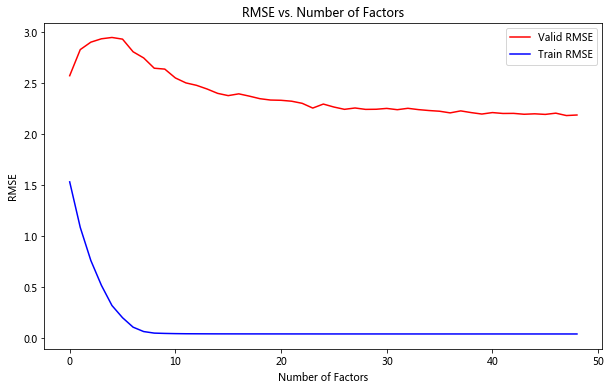

In [278]:
fig = plt.figure(figsize=(10,6))
plt.plot(valid_rmse, color='r', label='Valid RMSE')
plt.plot(train_rmse, color='b', label='Train RMSE')
plt.xlabel('Number of Factors')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs. Number of Factors');
# plt.savefig('tune_n_factors.png', bbox_inches='tight')

In [316]:
valid_rmse_r = []
train_rmse_r = []

for reg in [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    m1 = mf_model(train_sf, num_factors=10, regularization=reg)
    valid_rmse_r.append(np.sqrt(np.mean((np.array(valid_sf['user_rating']) - adjust_pred(m1.predict(valid_sf))) ** 2)))
    train_rmse_r.append(m1.training_rmse)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.122403s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-12    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 60us         | NA                     |

+---------+--------------+------------------------+

| 0       | 29.216ms     | 0.601552               |

| 1       | 75.808ms     | 0.349892               |

| 2       | 127.586ms    | 0.255006               |

| 3       | 177.949ms    | 0.206076               |

| 4       | 223.398ms    | 0.183623               |

| 5       | 261.773ms    | 0.153069               |

| 6       | 311.043ms    | 0.13492                |

| 7       | 344.427ms    | 0.139212               |

| 8       | 374.903ms    | 0.117105               |

| 9       | 420.067ms    | 0.170862               |

| 10      | 462.071ms    | 0.135723               |

| 11      | 501.047ms    | 0.103934               |

| 12      | 559.621ms    | 0.102418               |

| 13      | 599.536ms    | 0.0912862              |

| 14      | 630.365ms    | 0.0892387              |

| 15      | 662.053ms    | 0.087376               |

| 16      | 698.941ms    | 0.0884336              |

| 17      | 733.654ms    | 0.133098               |

| 18      | 759.965ms    | 0.0991764              |

| 19      | 795.823ms    | 0.0812193              |

| 20      | 827.07ms     | 0.0765356              |

| 21      | 857.562ms    | 0.0782303              |

| 22      | 890.407ms    | 0.0732964              |

| 23      | 920.737ms    | 0.0709368              |

| 24      | 949.841ms    | 0.0970244              |

| 25      | 980.662ms    | 0.0953696              |

| 26      | 1.01s        | 0.0954752              |

| 27      | 1.04s        | 0.0699605              |

| 28      | 1.07s        | 0.077838               |

| 29      | 1.10s        | 0.183093               |

| 30      | 1.13s        | 0.346018               |

| 31      | 1.16s        | 0.115109               |

| 32      | 1.19s        | 0.115755               |

| 33      | 1.22s        | 0.588798               |

| 34      | 1.26s        | 0.227967               |

| 35      | 1.29s        | 0.18415                |

| 36      | 1.32s        | 0.164517               |

| 37      | 1.35s        | 0.141032               |

| 38      | 1.38s        | 0.172104               |

| 39      | 1.41s        | 0.162398               |

| 40      | 1.45s        | 0.289514               |

| 41      | 1.49s        | 0.165448               |

| 42      | 1.52s        | 0.159298               |

| 43      | 1.55s        | 0.156324               |

| 44      | 1.58s        | 0.164122               |

| 45      | 1.62s        | 0.152266               |

| 46      | 1.66s        | 0.181081               |

| 47      | 1.69s        | 0.159565               |

| 48      | 1.72s        | 0.150408               |

| 49      | 1.75s        | 0.183023               |

| FINAL   | 1.75s        | 0.183023               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.057157s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-11    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 130us        | NA                     |

+---------+--------------+------------------------+

| 0       | 36.673ms     | 0.601552               |

| 1       | 68.495ms     | 0.349892               |

| 2       | 98.004ms     | 0.255006               |

| 3       | 126.062ms    | 0.206076               |

| 4       | 156.045ms    | 0.183623               |

| 5       | 189.165ms    | 0.153069               |

| 6       | 213.348ms    | 0.13492                |

| 7       | 236.73ms     | 0.139212               |

| 8       | 263.34ms     | 0.117105               |

| 9       | 289.231ms    | 0.170862               |

| 10      | 315.987ms    | 0.135723               |

| 11      | 338.815ms    | 0.103934               |

| 12      | 370.39ms     | 0.102418               |

| 13      | 392.913ms    | 0.0912862              |

| 14      | 420.95ms     | 0.0892387              |

| 15      | 449.052ms    | 0.087376               |

| 16      | 476.307ms    | 0.0884336              |

| 17      | 510.058ms    | 0.133098               |

| 18      | 538.248ms    | 0.0991764              |

| 19      | 562.394ms    | 0.0812193              |

| 20      | 590.209ms    | 0.0765356              |

| 21      | 617.01ms     | 0.0782303              |

| 22      | 644.864ms    | 0.0732964              |

| 23      | 671.206ms    | 0.0709368              |

| 24      | 698.446ms    | 0.0970244              |

| 25      | 732.554ms    | 0.0953696              |

| 26      | 758.584ms    | 0.0954752              |

| 27      | 786.051ms    | 0.0699605              |

| 28      | 814.35ms     | 0.077838               |

| 29      | 841.909ms    | 0.183093               |

| 30      | 870.068ms    | 0.346018               |

| 31      | 893.1ms      | 0.115109               |

| 32      | 923.924ms    | 0.115755               |

| 33      | 952.465ms    | 0.588798               |

| 34      | 976.848ms    | 0.227967               |

| 35      | 1.00s        | 0.18415                |

| 36      | 1.02s        | 0.164517               |

| 37      | 1.05s        | 0.141032               |

| 38      | 1.08s        | 0.172104               |

| 39      | 1.10s        | 0.162398               |

| 40      | 1.13s        | 0.289514               |

| 41      | 1.16s        | 0.165448               |

| 42      | 1.19s        | 0.159298               |

| 43      | 1.22s        | 0.156324               |

| 44      | 1.25s        | 0.164122               |

| 45      | 1.27s        | 0.152266               |

| 46      | 1.30s        | 0.181081               |

| 47      | 1.33s        | 0.159565               |

| 48      | 1.35s        | 0.150408               |

| 49      | 1.38s        | 0.183023               |

| FINAL   | 1.38s        | 0.183023               |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.03888s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-10    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 69us         | NA                     |

+---------+--------------+------------------------+

| 0       | 63.704ms     | 0.616048               |

| 1       | 103.547ms    | 0.352543               |

| 2       | 151.652ms    | 0.25814                |

| 3       | 189.658ms    | 0.205443               |

| 4       | 228.785ms    | 0.172593               |

| 5       | 251.601ms    | 0.149159               |

| 6       | 283.104ms    | 0.16378                |

| 7       | 314.097ms    | 0.160212               |

| 8       | 345.77ms     | 0.147151               |

| 9       | 368.793ms    | 0.120353               |

| 10      | 398.967ms    | 0.110741               |

| 11      | 436.608ms    | 0.103981               |

| 12      | 490.181ms    | 0.0989844              |

| 13      | 525.8ms      | 0.0970103              |

| 14      | 572.724ms    | 0.0930015              |

| 15      | 622.884ms    | 0.0895124              |

| 16      | 676.359ms    | 0.0952924              |

| 17      | 712.207ms    | 0.0951268              |

| 18      | 743.809ms    | 0.0891049              |

| 19      | 781.453ms    | 0.0984646              |

| 20      | 816.079ms    | 0.16385                |

| 21      | 863.257ms    | 0.129287               |

| 22      | 893.086ms    | 0.121841               |

| 23      | 920.539ms    | 0.153188               |

| 24      | 953.475ms    | 0.136225               |

| 25      | 983.382ms    | 0.115501               |

| 26      | 1.01s        | 0.154742               |

| 27      | 1.04s        | 0.135306               |

| 28      | 1.06s        | 0.115088               |

| 29      | 1.10s        | 0.114262               |

| 30      | 1.14s        | 0.107359               |

| 31      | 1.19s        | 0.113614               |

| 32      | 1.25s        | 0.116738               |

| 33      | 1.36s        | 0.133035               |

| 34      | 1.39s        | 0.133525               |

| 35      | 1.41s        | 0.103981               |

| 36      | 1.45s        | 0.116715               |

| 37      | 1.48s        | 0.110546               |

| 38      | 1.50s        | 0.116017               |

| 39      | 1.53s        | 0.107269               |

| 40      | 1.57s        | 0.109192               |

| 41      | 1.59s        | 0.119662               |

| 42      | 1.63s        | 0.116674               |

| 43      | 1.66s        | 0.114988               |

| 44      | 1.68s        | 0.102444               |

| 45      | 1.72s        | 0.108678               |

| 46      | 1.75s        | 0.107676               |

| 47      | 1.78s        | 0.109535               |

| 48      | 1.81s        | 0.673511               |

| 49      | 1.84s        | 0.16992                |

| FINAL   | 1.84s        | 0.16992                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.02975s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 318us        | NA                     |

+---------+--------------+------------------------+

| 0       | 41.906ms     | 0.774781               |

| 1       | 79.943ms     | 0.3339                 |

| 2       | 106.925ms    | 0.238176               |

| 3       | 132.681ms    | 0.190096               |

| 4       | 159.115ms    | 0.160661               |

| 5       | 194.676ms    | 0.145189               |

| 6       | 225.914ms    | 0.12015                |

| 7       | 259.086ms    | 0.105399               |

| 8       | 295.491ms    | 0.0914587              |

| 9       | 325.846ms    | 0.084261               |

| 10      | 359.653ms    | 0.142319               |

| 11      | 396.433ms    | 0.151129               |

| 12      | 422.162ms    | 0.0928561              |

| 13      | 453.313ms    | 0.108105               |

| 14      | 479.943ms    | 0.0836762              |

| 15      | 509.654ms    | 0.0946466              |

| 16      | 535.346ms    | 0.0800578              |

| 17      | 565.43ms     | 0.0671373              |

| 18      | 591.195ms    | 0.0996251              |

| 19      | 617.137ms    | 0.0990202              |

| 20      | 642.896ms    | 0.0741733              |

| 21      | 672.787ms    | 0.0578548              |

| 22      | 703.353ms    | 0.0882513              |

| 23      | 731.739ms    | 0.110365               |

| 24      | 758.907ms    | 0.115741               |

| 25      | 787.428ms    | 0.0626339              |

| 26      | 816.036ms    | 0.0460644              |

| 27      | 849.648ms    | 0.0863749              |

| 28      | 874.624ms    | 0.078592               |

| 29      | 906.984ms    | 0.0728137              |

| 30      | 937.123ms    | 0.0656257              |

| 31      | 969.287ms    | 0.0540254              |

| 32      | 1.01s        | 0.0575418              |

| 33      | 1.06s        | 0.0655105              |

| 34      | 1.12s        | 0.0658779              |

| 35      | 1.17s        | 0.0605542              |

| 36      | 1.19s        | 0.0701162              |

| 37      | 1.22s        | 0.0628953              |

| 38      | 1.25s        | 0.050534               |

| 39      | 1.28s        | 0.0514985              |

| 40      | 1.30s        | 0.0845108              |

| 41      | 1.33s        | 0.0637909              |

| 42      | 1.36s        | 0.0824933              |

| 43      | 1.40s        | 0.0757731              |

| 44      | 1.43s        | 0.0666416              |

| 45      | 1.45s        | 0.114525               |

| 46      | 1.48s        | 0.121879               |

| 47      | 1.51s        | 0.0952642              |

| 48      | 1.54s        | 0.0475318              |

| 49      | 1.57s        | 0.0502562              |

| FINAL   | 1.57s        | 0.0502562              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.031306s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-08    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 66us         | NA                     |

+---------+--------------+------------------------+

| 0       | 60.77ms      | 0.847649               |

| 1       | 89.574ms     | 0.30541                |

| 2       | 114.259ms    | 0.22246                |

| 3       | 144.431ms    | 0.177236               |

| 4       | 175.277ms    | 0.149291               |

| 5       | 213.891ms    | 0.12932                |

| 6       | 243.65ms     | 0.113523               |

| 7       | 276.105ms    | 0.100892               |

| 8       | 301.842ms    | 0.0904487              |

| 9       | 348.09ms     | 0.0821432              |

| 10      | 403.945ms    | 0.0906762              |

| 11      | 448.726ms    | 0.0765071              |

| 12      | 517.643ms    | 0.067058               |

| 13      | 569.347ms    | 0.0605875              |

| 14      | 613.255ms    | 0.0558477              |

| 15      | 647.099ms    | 0.108903               |

| 16      | 673.068ms    | 0.0886292              |

| 17      | 699.782ms    | 0.117926               |

| 18      | 730.872ms    | 0.14146                |

| 19      | 760.53ms     | 0.0841375              |

| 20      | 785.407ms    | 0.0869477              |

| 21      | 814.872ms    | 0.0653554              |

| 22      | 844.063ms    | 0.0527044              |

| 23      | 875.57ms     | 0.0798266              |

| 24      | 905.004ms    | 0.124857               |

| 25      | 936.688ms    | 0.0990698              |

| 26      | 965.51ms     | 0.104244               |

| 27      | 988.581ms    | 0.0668966              |

| 28      | 1.01s        | 0.0659468              |

| 29      | 1.04s        | 0.047775               |

| 30      | 1.07s        | 0.08829                |

| 31      | 1.10s        | 0.051408               |

| 32      | 1.13s        | 0.0389302              |

| 33      | 1.15s        | 0.0524554              |

| 34      | 1.18s        | 0.0747187              |

| 35      | 1.21s        | 0.0530058              |

| 36      | 1.23s        | 0.0581326              |

| 37      | 1.26s        | 0.0837541              |

| 38      | 1.30s        | 0.0490893              |

| 39      | 1.33s        | 0.0912933              |

| 40      | 1.36s        | 0.0763884              |

| 41      | 1.38s        | 0.0671776              |

| 42      | 1.41s        | 0.0645573              |

| 43      | 1.44s        | 0.0369404              |

| 44      | 1.46s        | 0.0426368              |

| 45      | 1.50s        | 0.0299975              |

| 46      | 1.52s        | 0.0314081              |

| 47      | 1.55s        | 0.0446297              |

| 48      | 1.59s        | 0.0830657              |

| 49      | 1.62s        | 0.0825106              |

| FINAL   | 1.62s        | 0.0825106              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029018s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-07    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 81us         | NA                     |

+---------+--------------+------------------------+

| 0       | 38.259ms     | 0.859763               |

| 1       | 67.417ms     | 0.283082               |

| 2       | 94.858ms     | 0.206468               |

| 3       | 120.386ms    | 0.166135               |

| 4       | 148.671ms    | 0.138989               |

| 5       | 174.201ms    | 0.119081               |

| 6       | 201.923ms    | 0.103957               |

| 7       | 228.633ms    | 0.092065               |

| 8       | 257.592ms    | 0.0824002              |

| 9       | 283.194ms    | 0.074359               |

| 10      | 308.86ms     | 0.0675                 |

| 11      | 335.123ms    | 0.061535               |

| 12      | 358.714ms    | 0.0562822              |

| 13      | 390.527ms    | 0.0516269              |

| 14      | 416.329ms    | 0.0474743              |

| 15      | 438.782ms    | 0.043756               |

| 16      | 468.878ms    | 0.0404189              |

| 17      | 496.774ms    | 0.0374215              |

| 18      | 524.68ms     | 0.0347261              |

| 19      | 551.668ms    | 0.0322956              |

| 20      | 578.803ms    | 0.0301046              |

| 21      | 612.618ms    | 0.0281256              |

| 22      | 637.796ms    | 0.0263354              |

| 23      | 663.791ms    | 0.0247123              |

| 24      | 689.062ms    | 0.0232408              |

| 25      | 722.307ms    | 0.0219024              |

| 26      | 753.757ms    | 0.0206857              |

| 27      | 783.74ms     | 0.0195663              |

| 28      | 813.348ms    | 0.0185474              |

| 29      | 835.601ms    | 0.0176152              |

| 30      | 868.833ms    | 0.0167603              |

| 31      | 894.407ms    | 0.0159746              |

| 32      | 926.359ms    | 0.0152521              |

| 33      | 953.663ms    | 0.0145864              |

| 34      | 980.535ms    | 0.0139725              |

| 35      | 1.00s        | 0.0134051              |

| 36      | 1.03s        | 0.0128802              |

| 37      | 1.06s        | 0.0123935              |

| 38      | 1.09s        | 0.0119408              |

| 39      | 1.12s        | 0.0115202              |

| 40      | 1.15s        | 0.0111276              |

| 41      | 1.17s        | 0.0107611              |

| 42      | 1.20s        | 0.0104183              |

| 43      | 1.23s        | 0.0100964              |

| 44      | 1.25s        | 0.00979403             |

| 45      | 1.28s        | 0.00950974             |

| 46      | 1.31s        | 0.00924111             |

| 47      | 1.33s        | 0.00898755             |

| 48      | 1.36s        | 0.0087477              |

| 49      | 1.39s        | 0.00852051             |

| FINAL   | 1.39s        | 0.00852051             |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.026625s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-06    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 82us         | NA                     |

+---------+--------------+------------------------+

| 0       | 47.804ms     | 0.878993               |

| 1       | 92.483ms     | 0.278559               |

| 2       | 116.233ms    | 0.199628               |

| 3       | 147.466ms    | 0.158595               |

| 4       | 172.006ms    | 0.131527               |

| 5       | 201.028ms    | 0.111818               |

| 6       | 229.689ms    | 0.0965919              |

| 7       | 267.736ms    | 0.0846126              |

| 8       | 296.707ms    | 0.0751782              |

| 9       | 323.886ms    | 0.0676164              |

| 10      | 350.765ms    | 0.061393               |

| 11      | 378.199ms    | 0.0561449              |

| 12      | 404.966ms    | 0.0516387              |

| 13      | 430.842ms    | 0.0477143              |

| 14      | 457.162ms    | 0.0442615              |

| 15      | 484.041ms    | 0.0411982              |

| 16      | 514.708ms    | 0.038464               |

| 17      | 540.266ms    | 0.0360119              |

| 18      | 566.179ms    | 0.0338071              |

| 19      | 594.101ms    | 0.0318214              |

| 20      | 618.276ms    | 0.0300311              |

| 21      | 646.724ms    | 0.0284145              |

| 22      | 672.489ms    | 0.0269533              |

| 23      | 700.606ms    | 0.02563                |

| 24      | 727.867ms    | 0.024429               |

| 25      | 751.521ms    | 0.0233361              |

| 26      | 773.715ms    | 0.0223388              |

| 27      | 801.045ms    | 0.0214258              |

| 28      | 830.75ms     | 0.0205875              |

| 29      | 857.827ms    | 0.0198168              |

| 30      | 885.32ms     | 0.0191073              |

| 31      | 911.468ms    | 0.0184533              |

| 32      | 938.613ms    | 0.0178496              |

| 33      | 965.861ms    | 0.0172914              |

| 34      | 994.536ms    | 0.0167746              |

| 35      | 1.02s        | 0.0162955              |

| 36      | 1.04s        | 0.0158508              |

| 37      | 1.07s        | 0.0154375              |

| 38      | 1.10s        | 0.0150526              |

| 39      | 1.13s        | 0.0146934              |

| 40      | 1.16s        | 0.0143575              |

| 41      | 1.19s        | 0.0140423              |

| 42      | 1.22s        | 0.0137452              |

| 43      | 1.24s        | 0.0134658              |

| 44      | 1.28s        | 0.0132043              |

| 45      | 1.33s        | 0.0129579              |

| 46      | 1.36s        | 0.0127263              |

| 47      | 1.40s        | 0.0125076              |

| 48      | 1.42s        | 0.0123007              |

| 49      | 1.45s        | 0.0121045              |

| FINAL   | 1.45s        | 0.0121045              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028958s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-05    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 69us         | NA                     |

+---------+--------------+------------------------+

| 0       | 65.561ms     | 1.83036                |

| 1       | 94.657ms     | 0.422821               |

| 2       | 125.726ms    | 0.318603               |

| 3       | 150.623ms    | 0.261622               |

| 4       | 179.683ms    | 0.222235               |

| 5       | 207.255ms    | 0.192946               |

| 6       | 233.134ms    | 0.170277               |

| 7       | 261.453ms    | 0.152322               |

| 8       | 290.164ms    | 0.137694               |

| 9       | 315.911ms    | 0.125477               |

| 10      | 343.828ms    | 0.115195               |

| 11      | 367.539ms    | 0.106533               |

| 12      | 401.872ms    | 0.0992192              |

| 13      | 428.555ms    | 0.0930107              |

| 14      | 454.418ms    | 0.0876991              |

| 15      | 483.939ms    | 0.0831105              |

| 16      | 511.397ms    | 0.0791067              |

| 17      | 539.543ms    | 0.0755825              |

| 18      | 566.833ms    | 0.0724594              |

| 19      | 594.582ms    | 0.0696776              |

| 20      | 621.957ms    | 0.0671904              |

| 21      | 650.88ms     | 0.06496                |

| 22      | 686.409ms    | 0.0629546              |

| 23      | 716.18ms     | 0.0611469              |

| 24      | 744.22ms     | 0.0595133              |

| 25      | 781.493ms    | 0.0580341              |

| 26      | 805.801ms    | 0.0566927              |

| 27      | 834.476ms    | 0.0554749              |

| 28      | 861.942ms    | 0.0543683              |

| 29      | 890.93ms     | 0.0533619              |

| 30      | 915.558ms    | 0.0524461              |

| 31      | 943.016ms    | 0.051612               |

| 32      | 967.278ms    | 0.0508514              |

| 33      | 996.398ms    | 0.0501568              |

| 34      | 1.01s        | 0.0495213              |

| 35      | 1.04s        | 0.0489387              |

| 36      | 1.07s        | 0.0484034              |

| 37      | 1.11s        | 0.0479105              |

| 38      | 1.14s        | 0.0474556              |

| 39      | 1.17s        | 0.0470346              |

| 40      | 1.20s        | 0.0466443              |

| 41      | 1.23s        | 0.0462817              |

| 42      | 1.28s        | 0.0459441              |

| 43      | 1.33s        | 0.0456293              |

| 44      | 1.41s        | 0.0453353              |

| 45      | 1.44s        | 0.0450602              |

| 46      | 1.48s        | 0.0448024              |

| 47      | 1.51s        | 0.0445605              |

| 48      | 1.53s        | 0.0443332              |

| 49      | 1.57s        | 0.0441191              |

| FINAL   | 1.57s        | 0.0441191              |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.063923s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 0.0001   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 177us        | NA                     |

+---------+--------------+------------------------+

| 0       | 58.278ms     | 2.09927                |

| 1       | 93.185ms     | 1.31248                |

| 2       | 143.95ms     | 0.516132               |

| 3       | 193.892ms    | 0.430538               |

| 4       | 244.066ms    | 0.396012               |

| 5       | 284.093ms    | 0.382075               |

| 6       | 326.521ms    | 0.374482               |

| 7       | 360.929ms    | 0.369519               |

| 8       | 392.5ms      | 0.365989               |

| 9       | 431.53ms     | 0.363341               |

| 10      | 455.497ms    | 0.361307               |

| 11      | 496.776ms    | 0.359696               |

| 12      | 527.751ms    | 0.358373               |

| 13      | 564.415ms    | 0.357257               |

| 14      | 598.227ms    | 0.356294               |

| 15      | 629.782ms    | 0.35545                |

| 16      | 670.936ms    | 0.354704               |

| 17      | 714.21ms     | 0.35404                |

| 18      | 759.584ms    | 0.353443               |

| 19      | 809.171ms    | 0.3529                 |

| 20      | 862.244ms    | 0.352403               |

| 21      | 899.359ms    | 0.351944               |

| 22      | 946.609ms    | 0.351518               |

| 23      | 983.019ms    | 0.351122               |

| 24      | 1.01s        | 0.350751               |

| 25      | 1.06s        | 0.350405               |

| 26      | 1.09s        | 0.350081               |

| 27      | 1.11s        | 0.349778               |

| 28      | 1.14s        | 0.349494               |

| 29      | 1.17s        | 0.349229               |

| 30      | 1.20s        | 0.34898                |

| 31      | 1.23s        | 0.348746               |

| 32      | 1.26s        | 0.348527               |

| 33      | 1.29s        | 0.348321               |

| 34      | 1.33s        | 0.348128               |

| 35      | 1.36s        | 0.347948               |

| 36      | 1.39s        | 0.347779               |

| 37      | 1.42s        | 0.347621               |

| 38      | 1.45s        | 0.347474               |

| 39      | 1.48s        | 0.347337               |

| 40      | 1.52s        | 0.34721                |

| 41      | 1.56s        | 0.347092               |

| 42      | 1.59s        | 0.346982               |

| 43      | 1.62s        | 0.346879               |

| 44      | 1.65s        | 0.346784               |

| 45      | 1.68s        | 0.346695               |

| 46      | 1.72s        | 0.346611               |

| 47      | 1.74s        | 0.346533               |

| 48      | 1.77s        | 0.346459               |

| 49      | 1.80s        | 0.34639                |

| FINAL   | 1.80s        | 0.34639                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.027597s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 76us         | NA                     |

+---------+--------------+------------------------+

| 0       | 40.296ms     | 2.09971                |

| 1       | 69.195ms     | 2.09971                |

| 2       | 100.374ms    | 2.09969                |

| 3       | 128.662ms    | 2.09949                |

| 4       | 162.397ms    | 2.09691                |

| 5       | 194.598ms    | 2.0761                 |

| 6       | 218.444ms    | 2.01646                |

| 7       | 242.333ms    | 1.93753                |

| 8       | 272.031ms    | 1.87466                |

| 9       | 301.215ms    | 1.83474                |

| 10      | 328.599ms    | 1.80985                |

| 11      | 355.752ms    | 1.79421                |

| 12      | 386.775ms    | 1.78405                |

| 13      | 413.424ms    | 1.77717                |

| 14      | 442.882ms    | 1.77231                |

| 15      | 467.582ms    | 1.76875                |

| 16      | 495.966ms    | 1.76606                |

| 17      | 529.019ms    | 1.76397                |

| 18      | 552.701ms    | 1.76232                |

| 19      | 582.815ms    | 1.761                  |

| 20      | 612.97ms     | 1.75993                |

| 21      | 647.389ms    | 1.75906                |

| 22      | 675.313ms    | 1.75834                |

| 23      | 704.286ms    | 1.75773                |

| 24      | 728.466ms    | 1.75723                |

| 25      | 757.925ms    | 1.75679                |

| 26      | 787.043ms    | 1.75642                |

| 27      | 815.321ms    | 1.7561                 |

| 28      | 841.139ms    | 1.75582                |

| 29      | 870.286ms    | 1.75557                |

| 30      | 893.58ms     | 1.75535                |

| 31      | 921.361ms    | 1.75515                |

| 32      | 950.179ms    | 1.75498                |

| 33      | 994.075ms    | 1.75481                |

| 34      | 1.02s        | 1.75467                |

| 35      | 1.05s        | 1.75453                |

| 36      | 1.07s        | 1.7544                 |

| 37      | 1.10s        | 1.75429                |

| 38      | 1.13s        | 1.75418                |

| 39      | 1.15s        | 1.75408                |

| 40      | 1.18s        | 1.75398                |

| 41      | 1.20s        | 1.75389                |

| 42      | 1.23s        | 1.7538                 |

| 43      | 1.26s        | 1.75372                |

| 44      | 1.28s        | 1.75365                |

| 45      | 1.31s        | 1.75357                |

| 46      | 1.34s        | 1.7535                 |

| 47      | 1.37s        | 1.75344                |

| 48      | 1.40s        | 1.75337                |

| 49      | 1.42s        | 1.75331                |

| FINAL   | 1.42s        | 1.75331                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.029969s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 0.01     |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 168us        | NA                     |

+---------+--------------+------------------------+

| 0       | 41.481ms     | 2.09971                |

| 1       | 75.367ms     | 2.09971                |

| 2       | 120.884ms    | 2.09971                |

| 3       | 161.335ms    | 2.09971                |

| 4       | 202.645ms    | 2.09971                |

| 5       | 238.991ms    | 2.09971                |

| 6       | 268.019ms    | 2.09971                |

| 7       | 299.866ms    | 2.09971                |

| 8       | 330.837ms    | 2.09971                |

| 9       | 390.252ms    | 2.09971                |

| 10      | 444.876ms    | 2.09971                |

| 11      | 496.952ms    | 2.09971                |

| 12      | 544.5ms      | 2.09971                |

| 13      | 580.823ms    | 2.09971                |

| 14      | 608.552ms    | 2.09971                |

| 15      | 634.274ms    | 2.09971                |

| 16      | 665.396ms    | 2.09971                |

| 17      | 690.717ms    | 2.09971                |

| 18      | 724.406ms    | 2.09971                |

| 19      | 749.618ms    | 2.09971                |

| 20      | 770.685ms    | 2.09971                |

| 21      | 798.613ms    | 2.09971                |

| 22      | 831.767ms    | 2.09971                |

| 23      | 861.343ms    | 2.09971                |

| 24      | 894.209ms    | 2.09971                |

| 25      | 930.758ms    | 2.09971                |

| 26      | 966.007ms    | 2.09971                |

| 27      | 996.88ms     | 2.09971                |

| 28      | 1.02s        | 2.09971                |

| 29      | 1.05s        | 2.09971                |

| 30      | 1.08s        | 2.09971                |

| 31      | 1.10s        | 2.09971                |

| 32      | 1.13s        | 2.09971                |

| 33      | 1.16s        | 2.09971                |

| 34      | 1.18s        | 2.09971                |

| 35      | 1.22s        | 2.09971                |

| 36      | 1.25s        | 2.09971                |

| 37      | 1.28s        | 2.09971                |

| 38      | 1.30s        | 2.09971                |

| 39      | 1.33s        | 2.09971                |

| 40      | 1.36s        | 2.09971                |

| 41      | 1.40s        | 2.09971                |

| 42      | 1.43s        | 2.09971                |

| 43      | 1.46s        | 2.09971                |

| 44      | 1.49s        | 2.09971                |

| 45      | 1.52s        | 2.09971                |

| 46      | 1.54s        | 2.09971                |

| 47      | 1.57s        | 2.09971                |

| 48      | 1.60s        | 2.09971                |

| 49      | 1.63s        | 2.09971                |

| FINAL   | 1.63s        | 2.09971                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.028467s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 0.1      |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 67us         | NA                     |

+---------+--------------+------------------------+

| 0       | 48.728ms     | 2.09971                |

| 1       | 88.053ms     | 2.09971                |

| 2       | 128.359ms    | 2.09971                |

| 3       | 163.328ms    | 2.09971                |

| 4       | 213.157ms    | 2.09971                |

| 5       | 251.067ms    | 2.09971                |

| 6       | 278.283ms    | 2.09971                |

| 7       | 307.763ms    | 2.09971                |

| 8       | 333.991ms    | 2.09971                |

| 9       | 365.962ms    | 2.09971                |

| 10      | 418.41ms     | 2.09971                |

| 11      | 471.056ms    | 2.09971                |

| 12      | 498.079ms    | 2.09971                |

| 13      | 523.224ms    | 2.09971                |

| 14      | 550.955ms    | 2.09971                |

| 15      | 580.727ms    | 2.09971                |

| 16      | 610.423ms    | 2.09971                |

| 17      | 639.3ms      | 2.09971                |

| 18      | 663.105ms    | 2.09971                |

| 19      | 692.617ms    | 2.09971                |

| 20      | 722.031ms    | 2.09971                |

| 21      | 749.052ms    | 2.09971                |

| 22      | 775.159ms    | 2.09971                |

| 23      | 799.629ms    | 2.09971                |

| 24      | 834.82ms     | 2.09971                |

| 25      | 863.405ms    | 2.09971                |

| 26      | 889.756ms    | 2.09971                |

| 27      | 916.119ms    | 2.09971                |

| 28      | 943.601ms    | 2.09971                |

| 29      | 978.78ms     | 2.09971                |

| 30      | 1.00s        | 2.09971                |

| 31      | 1.03s        | 2.09971                |

| 32      | 1.07s        | 2.09971                |

| 33      | 1.09s        | 2.09971                |

| 34      | 1.12s        | 2.09971                |

| 35      | 1.15s        | 2.09971                |

| 36      | 1.17s        | 2.09971                |

| 37      | 1.21s        | 2.09971                |

| 38      | 1.23s        | 2.09971                |

| 39      | 1.26s        | 2.09971                |

| 40      | 1.29s        | 2.09971                |

| 41      | 1.32s        | 2.09971                |

| 42      | 1.35s        | 2.09971                |

| 43      | 1.38s        | 2.09971                |

| 44      | 1.41s        | 2.09971                |

| 45      | 1.43s        | 2.09971                |

| 46      | 1.46s        | 2.09971                |

| 47      | 1.48s        | 2.09971                |

| 48      | 1.51s        | 2.09971                |

| 49      | 1.54s        | 2.09971                |

| FINAL   | 1.54s        | 2.09971                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

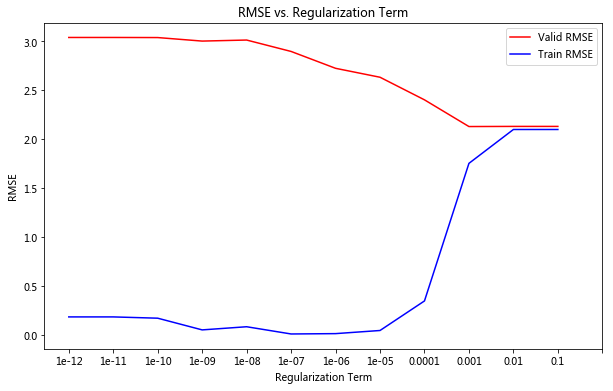

In [317]:
fig = plt.figure(figsize=(10,6))
plt.plot(valid_rmse_r, color='r', label='Valid RMSE')
plt.plot(train_rmse_r, color='b', label='Train RMSE')
plt.xlabel('Regularization Term')
plt.ylabel('RMSE')
plt.legend()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
plt.title('RMSE vs. Regularization Term')
plt.savefig('tune_interaction_regularization.png', bbox_inches='tight')

In [318]:
valid_rmse_r

[3.0407979845728921,
 3.0407979845728921,
 3.0397984297068388,
 3.0038024295758476,
 3.0144372201779368,
 2.897807563648743,
 2.7254310681470724,
 2.63401377717204,
 2.4029145925877651,
 2.1298194148207203,
 2.1312317628971806,
 2.1312317628971806]

In [406]:
m_final = gl.factorization_recommender.create(train_sf,
                                            regularization=1e-3,
                                            linear_regularization=1e-8,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=8, # Number of latent factors.
                                            solver='als')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 12753 observations with 2658 users and 2280 items.

Data prepared in: 0.158206s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 68us         | NA                     |

+---------+--------------+------------------------+

| 0       | 29.983ms     | 2.09971                |

| 1       | 64.447ms     | 2.09971                |

| 2       | 103.624ms    | 2.09969                |

| 3       | 142.14ms     | 2.09943                |

| 4       | 174.321ms    | 2.09617                |

| 5       | 204.756ms    | 2.07303                |

| 6       | 237.652ms    | 2.01275                |

| 7       | 267.909ms    | 1.94184                |

| 8       | 302.403ms    | 1.88608                |

| 9       | 332.021ms    | 1.84704                |

| 10      | 373.188ms    | 1.82094                |

| 11      | 403.888ms    | 1.80412                |

| 12      | 433.1ms      | 1.79305                |

| 13      | 460.614ms    | 1.78547                |

| 14      | 492.981ms    | 1.78007                |

| 15      | 526.717ms    | 1.77609                |

| 16      | 563.907ms    | 1.77309                |

| 17      | 599.715ms    | 1.77077                |

| 18      | 623.456ms    | 1.76896                |

| 19      | 661.15ms     | 1.76753                |

| 20      | 693.825ms    | 1.76637                |

| 21      | 727.124ms    | 1.76542                |

| 22      | 781.958ms    | 1.76463                |

| 23      | 812.275ms    | 1.76397                |

| 24      | 849.017ms    | 1.76342                |

| 25      | 894.351ms    | 1.76293                |

| 26      | 918.502ms    | 1.76252                |

| 27      | 941.091ms    | 1.76215                |

| 28      | 967.401ms    | 1.76183                |

| 29      | 1.03s        | 1.76154                |

| 30      | 1.06s        | 1.76127                |

| 31      | 1.13s        | 1.76104                |

| 32      | 1.17s        | 1.76082                |

| 33      | 1.22s        | 1.76062                |

| 34      | 1.26s        | 1.76044                |

| 35      | 1.29s        | 1.76027                |

| 36      | 1.32s        | 1.76011                |

| 37      | 1.37s        | 1.75997                |

| 38      | 1.40s        | 1.75983                |

| 39      | 1.44s        | 1.7597                 |

| 40      | 1.51s        | 1.75958                |

| 41      | 1.54s        | 1.75947                |

| 42      | 1.58s        | 1.75936                |

| 43      | 1.61s        | 1.75926                |

| 44      | 1.65s        | 1.75917                |

| 45      | 1.67s        | 1.75908                |

| 46      | 1.70s        | 1.759                  |

| 47      | 1.72s        | 1.75892                |

| 48      | 1.76s        | 1.75885                |

| 49      | 1.79s        | 1.75878                |

| FINAL   | 1.79s        | 1.75878                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

In [407]:
np.sqrt(np.mean((np.array(test_sf['user_rating']) - adjust_pred(m_final.predict(test_sf))) ** 2))

2.1124997951053506

In [408]:
m_final.training_rmse

1.7587768837073248

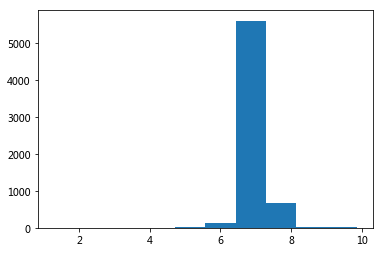

In [409]:
# my model predicted rating distribution on validation set
plt.hist(adjust_pred(m_final.predict(valid_sf)));

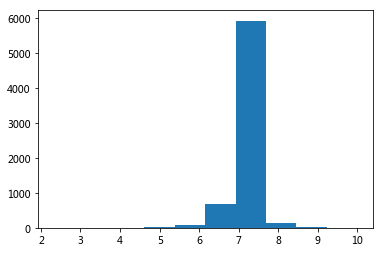

In [410]:
# my model predicted rating distribution on test set
plt.hist(adjust_pred(m_final.predict(test_sf)));

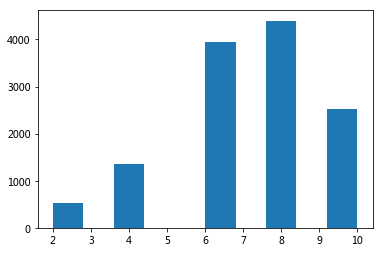

In [411]:
# original rating distribution
plt.hist(train['user_rating']);

In [339]:
m_final.evaluate_rmse(test_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1707
 
 Data:
 +------------+-------+----------------+
 | perfume_id | count |      rmse      |
 +------------+-------+----------------+
 |   983725   |   1   | 2.89363785439  |
 |   690443   |   30  | 2.33533315659  |
 |   309189   |   8   | 1.40268098405  |
 |   654495   |   9   | 2.10122714369  |
 |   860793   |   4   | 2.54342067864  |
 |   884943   |   1   |  2.9046952444  |
 |   329998   |   2   |  2.8938846217  |
 |   460995   |   5   | 2.15481163378  |
 |   206222   |   21  | 1.75919192595  |
 |   797238   |   1   | 0.915708411382 |
 +------------+-------+----------------+
 [1707 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+----------------+
 | user_id  | count |      rmse      |
 +----------+

In [340]:
m_final.evaluate_rmse(valid_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1696
 
 Data:
 +------------+-------+----------------+
 | perfume_id | count |      rmse      |
 +------------+-------+----------------+
 |   765931   |   1   | 1.10609268407  |
 |   983725   |   2   | 2.12732832337  |
 |   690443   |   19  | 2.06223400743  |
 |   309189   |   5   | 3.03921497342  |
 |   654495   |   5   | 2.02178675923  |
 |   860793   |   1   |  1.0996223284  |
 |   884943   |   1   | 0.851304426686 |
 |   912526   |   1   | 2.88711522323  |
 |   329998   |   1   | 0.894414554247 |
 |   460995   |   5   | 2.72569012593  |
 +------------+-------+----------------+
 [1696 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+----------------+
 | user_id  | count |      rmse      |
 +----------+

In [348]:
m_all_data = gl.factorization_recommender.create(train_and_valid_sf,
                                            regularization=0.001,
                                            linear_regularization=1e-8,
                                            user_id='user_id',
                                            item_id='perfume_id',
                                            target='user_rating',
                                            num_factors=8, # Number of latent factors.
                                            solver='als')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 19245 observations with 2658 users and 2718 items.

Data prepared in: 0.108456s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 0.001    |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 60us         | NA                     |

+---------+--------------+------------------------+

| 0       | 45.22ms      | 2.1104                 |

| 1       | 84.249ms     | 2.1104                 |

| 2       | 119.872ms    | 2.1104                 |

| 3       | 157.41ms     | 2.11038                |

| 4       | 199.249ms    | 2.1103                 |

| 5       | 235.117ms    | 2.1097                 |

| 6       | 284.99ms     | 2.10551                |

| 7       | 319.398ms    | 2.08741                |

| 8       | 377.507ms    | 2.05607                |

| 9       | 438.423ms    | 2.02648                |

| 10      | 488.585ms    | 2.00412                |

| 11      | 523.833ms    | 1.98732                |

| 12      | 547.988ms    | 1.974                  |

| 13      | 584.122ms    | 1.96345                |

| 14      | 633.553ms    | 1.95523                |

| 15      | 665.757ms    | 1.94877                |

| 16      | 714.634ms    | 1.9436                 |

| 17      | 754.317ms    | 1.93937                |

| 18      | 782.505ms    | 1.93584                |

| 19      | 822.556ms    | 1.93286                |

| 20      | 864.379ms    | 1.93033                |

| 21      | 898.819ms    | 1.92818                |

| 22      | 936.553ms    | 1.92637                |

| 23      | 974.447ms    | 1.92486                |

| 24      | 1.01s        | 1.92359                |

| 25      | 1.05s        | 1.92254                |

| 26      | 1.08s        | 1.92166                |

| 27      | 1.13s        | 1.92092                |

| 28      | 1.16s        | 1.9203                 |

| 29      | 1.20s        | 1.91978                |

| 30      | 1.25s        | 1.91934                |

| 31      | 1.28s        | 1.91896                |

| 32      | 1.33s        | 1.91863                |

| 33      | 1.37s        | 1.91834                |

| 34      | 1.41s        | 1.9181                 |

| 35      | 1.46s        | 1.91788                |

| 36      | 1.50s        | 1.91769                |

| 37      | 1.54s        | 1.91752                |

| 38      | 1.56s        | 1.91737                |

| 39      | 1.60s        | 1.91723                |

| 40      | 1.65s        | 1.91711                |

| 41      | 1.71s        | 1.917                  |

| 42      | 1.76s        | 1.9169                 |

| 43      | 1.80s        | 1.91681                |

| 44      | 1.84s        | 1.91673                |

| 45      | 1.89s        | 1.91666                |

| 46      | 1.94s        | 1.91659                |

| 47      | 2.01s        | 1.91653                |

| 48      | 2.08s        | 1.91647                |

| 49      | 2.12s        | 1.91642                |

| FINAL   | 2.12s        | 1.91642                |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

In [351]:
m_all_data.evaluate_rmse(test_sf, target='user_rating')

{'rmse_by_item': Columns:
 	perfume_id	int
 	count	int
 	rmse	float
 
 Rows: 1707
 
 Data:
 +------------+-------+----------------+
 | perfume_id | count |      rmse      |
 +------------+-------+----------------+
 |   983725   |   1   | 2.92037450338  |
 |   690443   |   30  | 2.22393400173  |
 |   309189   |   8   | 1.39150477143  |
 |   654495   |   9   | 2.08807958291  |
 |   860793   |   4   | 2.53659019293  |
 |   884943   |   1   |  2.909820525   |
 |   329998   |   2   | 2.89106008237  |
 |   460995   |   5   | 2.14990421101  |
 |   206222   |   21  | 1.72050257345  |
 |   797238   |   1   | 0.827337494146 |
 +------------+-------+----------------+
 [1707 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 2658
 
 Data:
 +----------+-------+----------------+
 | user_id  | count |      rmse      |
 +----------+

## Check Latent Fetures

In [359]:
coeffs = m_all_data.get('coefficients')
user_factors = coeffs['user_id']['factors'].to_numpy()
perfume_factors = coeffs['perfume_id']['factors'].to_numpy().T

In [364]:
coeffs

{'intercept': 7.108859444011437, 'perfume_id': Columns:
 	perfume_id	int
 	linear_terms	float
 	factors	array
 
 Rows: 2718
 
 Data:
 +------------+--------------+-------------------------------+
 | perfume_id | linear_terms |            factors            |
 +------------+--------------+-------------------------------+
 |   976148   |     0.0      | [-0.0167327225208, -0.0174... |
 |   405595   |     0.0      | [-0.014452598989, 0.018150... |
 |   993237   |     0.0      | [-0.0103762391955, -0.0033... |
 |   895245   |     0.0      | [0.00052911991952, -0.0014... |
 |   848827   |     0.0      | [0.000163091419381, -0.000... |
 |   342211   |     0.0      | [0.000163091419381, -0.000... |
 |   741296   |     0.0      | [0.0547553263605, -0.04822... |
 |   515909   |     0.0      | [-0.710078656673, -0.48661... |
 |   587576   |     0.0      | [-0.0562092326581, 0.25243... |
 |   234893   |     0.0      | [0.317634195089, 0.9956855... |
 +------------+--------------+------------------

In [393]:
train_and_valid['perfume_id'].unique()

array([976148, 405595, 993237, ..., 765931, 686358, 894351])

In [390]:
perfume_factors.shape

(8, 2718)

In [360]:
user_factors

array([[ 0.00352248, -0.00977459, -0.00314924, ..., -0.03376171,
        -0.01446882, -0.00019237],
       [-0.11526047, -0.10651442,  0.01483759, ..., -0.13640846,
         0.0507702 , -0.04083432],
       [-0.11953022,  0.09134853, -0.06695152, ...,  0.01407885,
        -0.11004173, -0.09560868],
       ..., 
       [ 0.00751055,  0.01679653,  0.00721972, ..., -0.02184595,
        -0.00262264,  0.01323576],
       [ 0.00489165, -0.00178712,  0.02088848, ..., -0.00603415,
        -0.00814143, -0.00330013],
       [-0.07096656, -0.11869752, -0.06099418, ...,  0.16308701,
         0.00955954, -0.03502456]])

In [380]:
perfume_factors_sorted = np.argsort(perfume_factors, axis = 1)[:,-15:]
perfume_factors_sorted

array([[ 192,  299,  465,  116,  459,  474,  320,  467,  381,  349,  458,
          34,  434,  142,  108],
       [ 774,  434,   20,  476,  192,   64,   21,  490,  497,  485,  315,
           9,  465,  189,  116],
       [ 382,   49,   45,  194,  447,  200,  381,  475,  458,  327,  189,
          16,  434,  376,  410],
       [1476, 1600, 1615, 1604, 1594, 1614, 1164, 1598,  296, 1229, 1599,
         551,  826,  758, 1122],
       [ 551,  198,  220,  240,  112,  479,  116,   11,  317,  333,  327,
         549, 1067,  209,  381],
       [ 362,  525,  494,  107,  531,  645,  220,  117,   19,   37,   41,
         222,  189,  215,  447],
       [1540, 1038,  774,  206,  450,   50,  708,    7,  720,  465,   20,
         659,  202,  116,  322],
       [ 122,  238,  500,  110,  239,  453,  209, 1067,  456,   30,  551,
         549,  476,  333,  215]])

In [385]:
perfume_info = pd.read_csv('data/perfume_features.csv')

### 1. Latent Feature 1

In [394]:
cluster1 = [train_and_valid['perfume_id'].unique()[i-1] for i in perfume_factors_sorted[0]][::-1]
perfume_info[perfume_info['perfume_id'].isin(cluster1)]

,Unnamed: 0,perfume_id,brand,gender,item_name,note,perfumer,tags,theme,url
1932,1932,982978,三宅一生,男香,三宅一生 一生之水男士 Issey Miyake L'Eau d'Issey Pour Ho...,"[芫荽, 柏树, 橘子, 龙蒿, 日本柚子, 柠檬马鞭草, 鼠尾草, 香柠檬, 柠檬, 西瓜...",Jacques Cavallier,"[柑橘, 浓郁, 清新辛辣, 绿叶, 花香, 木香]",水生木质调,/xiangshui/982978-issey-miyake-pour-homme.html
2165,2165,975133,橘滋,女香,"橘滋 甜美万岁（花朵万岁） Juicy Couture Viva la Juicy, 2008","[橘子, 森林水果, 忍冬, 栀子花, 茉莉, 琥珀, 焦糖, 果仁糖, 檀香木, 香草]",NaN,"[白色花, 甜, 焦糖, 果香, 香草, 柑橘]",花果香美食调,/xiangshui/975133-juzi-juicy-couture-viva.html
2891,2891,766253,浪凡,女香,"浪凡 光韵 Lanvin Eclat d’Arpège, 2002","[牡丹, 桃花, 茶叶, 紫丁香, 琥珀, 麝香, 桂花, 苦橙叶, 雪松, 紫藤]",Karine Dubreuil,"[花香, 清新, 绿叶, 麝香, 果香, 水生]",花香果香调,/xiangshui/766253-langfan-guangyun-lanvin-ecla...
4952,4952,264532,潘海利根,中性香,"潘海利根 瓦拉 Penhaligon`s Vaara, 2013","[木梨, 玫瑰, 胡萝卜籽, 芫荽, 藏红花, 玫瑰, 小苍兰, 木兰, 牡丹, 蜂蜜, 麝...",Bertrand Duchaufour,"[花香, 玫瑰, 果香, 甜, 清新, 温暖辛辣]",东方调,/xiangshui/264532-panhailigen-wala-penhaligon-...
6138,6138,133844,芦丹氏,中性香,"芦丹氏 修女（宗教） Serge Lutens La Religieuse, 2015","[茉莉, 麝猫香, 麝香, 焚香]",Christopher Sheldrake,"[白色花, 麝香, 动物, 树脂, 烟熏]",东方花香调,/xiangshui/133844-la-religieuse.html
6142,6142,310540,芦丹氏,中性香,"芦丹氏 黑色赛吉 Serge Lutens Serge Noire, 2008","[广藿香, 肉桂, 琥珀, 木质香, 焚香, 公丁香, 辛香料, 黑檀]",Christopher Sheldrake,"[温暖辛辣, 树脂, 木香, 烟熏, 桂皮]",东方调,/xiangshui/310540-ludanshi-heisesaiji-serge-lu...
7432,7432,287001,马克·雅可布,女香,"马克·雅可布 梦幻小雏菊（雏菊之梦） Marc Jacobs Daisy Dream, 2014","[黑莓, 葡萄柚, 梨, 紫藤, 茉莉, 荔枝, 木质香, 麝香, 椰子]",Ann Gottlieb,"[果香, 清新, 花香, 甜, 热带水果]",花香果香调,/xiangshui/287001-menghuanxiaochuju-daisy-drea...
7469,7469,815925,马丁·马吉拉 MMM,女香,马丁·马吉拉 MMM 绿茶逃逸 Maison Martin Margiela Tea Esc...,"[香柠檬, 粉红胡椒, 薄荷, 茶叶, 茉莉, 桂花, 大米, 马黛茶, 牛奶]",Fabrice Pellegrin,"[绿叶, 清新, 牛奶, 清新辛辣, 水生, 白色花]",花香调,/xiangshui/815925-maison-martin-margiela-tea-e...
9151,9151,234600,纳茜素,女香,"纳茜素 玫瑰麝香 Narciso Rodriguez Fleur Musc for Her,...","[粉红胡椒, 玫瑰, 牡丹, 麝香, 广藿香, 琥珀, 紫罗兰]",Sonia Constant,"[玫瑰, 花香, 麝香, 清新, 广藿香]",木质花香调,/xiangshui/234600-narciso-rodriguez-fleur-musc...
9850,9850,932036,潘海利根,女香,"潘海利根 艾蒿（致命温柔） Penhaligon`s Artemisia, 2002","[油桃, 绿叶, 苹果, 铃兰, 茉莉, 茶叶, 紫罗兰, 香草, 橡木苔, 檀香木, 麝香...",NaN,"[脂粉, 木香, 绿叶, 花香, 麝香]",东方调,/xiangshui/932036-panhailigen-aihao-penhaligon...


In [395]:
cluster2 = [train_and_valid['perfume_id'].unique()[i-1] for i in perfume_factors_sorted[1]][::-1]
perfume_info[perfume_info['perfume_id'].isin(cluster2)]

,Unnamed: 0,perfume_id,brand,gender,item_name,note,perfumer,tags,theme,url
472,472,370823,伊丽莎白雅顿,女香,"伊丽莎白雅顿 绿茶 Elizabeth Arden Green Tea, 1999","[大黄, 薄荷, 橙子, 香柠檬, 柠檬, 康乃馨, 麝香, 茉莉, 橡木苔, 琥珀, 小茴...",Francis Kurkdjian,"[绿叶, 柑橘, 浓郁, 清新辛辣, 水生, 清新]",柑橘馥奇香调,/xiangshui/370823-lucha-elizabeth-arden-green....
1243,1243,529098,娇兰,男香,"娇兰 满堂红 Guerlain Habit Rouge Eau de Toilette, 1965","[橙子, 罗勒, 香柠檬, 巴西红木, 柠檬, 青柠, 蜜橘, 康乃馨, 檀香木, 广藿香,...",Jean-Paul Guerlain,"[柑橘, 木香, 树脂, 温暖辛辣, 香草]",木质东方调,/xiangshui/529098-jiaolan-mantanghong-guerlain...
1577,1577,476435,爱马仕,女香,"爱马仕 橘采星光（橘彩） Hermes Eau des Merveilles, 2004","[橙子, 柠檬, 榄香脂, 琥珀, 粉红胡椒, 紫罗兰, 胡椒, 冷杉, 橡木苔, 雪松, ...",Nathalie Feisthauer,"[木香, 清新辛辣, 柑橘, 浓郁, 琥珀, 树脂]",木质东方调,/xiangshui/476435-aimashi-jucai-hermes-merveil...
2891,2891,766253,浪凡,女香,"浪凡 光韵 Lanvin Eclat d’Arpège, 2002","[牡丹, 桃花, 茶叶, 紫丁香, 琥珀, 麝香, 桂花, 苦橙叶, 雪松, 紫藤]",Karine Dubreuil,"[花香, 清新, 绿叶, 麝香, 果香, 水生]",花香果香调,/xiangshui/766253-langfan-guangyun-lanvin-ecla...
2922,2922,582452,欧舒丹,女香,"欧舒丹 樱花 L`Occitane en Provence Cherry Blossom, ...","[樱桃, 小苍兰, 黑加仑, 铃兰, 樱花, 巴西红木, 琥珀, 麝香]",NaN,"[花香, 果香, 樱桃, 清新, 甜]",花香调,/xiangshui/582452-oushudan-yinghua-occitane-pr...
4952,4952,264532,潘海利根,中性香,"潘海利根 瓦拉 Penhaligon`s Vaara, 2013","[木梨, 玫瑰, 胡萝卜籽, 芫荽, 藏红花, 玫瑰, 小苍兰, 木兰, 牡丹, 蜂蜜, 麝...",Bertrand Duchaufour,"[花香, 玫瑰, 果香, 甜, 清新, 温暖辛辣]",东方调,/xiangshui/264532-panhailigen-wala-penhaligon-...
12940,12940,102121,宝格丽,男香,"宝格丽 大吉岭茶 Bvlgari Pour Homme, 1996","[醛, 薰衣草, 橘子, 茶叶, 肉豆蔻, 香柠檬, 橙花, 仙客来, 芫荽, 康乃馨, 鸢...",Jacques Cavallier,"[木香, 绿叶, 清新辛辣, 浓郁, 柑橘, 麝香]",木质花香调,/xiangshui/102121-baogeli-dajilingcha-bvlgari....
13541,13541,751546,凯文克莱,中性香,"凯文克莱 二 Calvin Klein CK2, 2016","[芥末, 橘子, 紫罗兰叶, 梨, 鹅卵石, 鸢尾根, 玫瑰, 牡丹, 希蒂莺, 香根草, ...",Pascal Gaurin,"[木香, 水生, 绿叶, 水感, 柑橘]",木质馥奇香调,/xiangshui/751546-calvin-klein-ck2.html
13570,13570,636676,卡地亚,男香,"卡地亚 宣言 Cartier Declaration, 1998","[艾蒿, 葛缕子, 芫荽, 桦木, 橘子, 香柠檬, 橙花油, 苦橙, 鸢尾花, 生姜, 肉...",Jean-Claude Ellena,"[清新辛辣, 浓郁, 木香, 柑橘, 温暖辛辣]",木质花香调,/xiangshui/636676-kadiya-xuanyan-cartier-decla...
14280,14280,623126,蒂普提克,女香,"蒂普提克 杜桑（晚香玉） Diptyque Do Son, 2005","[橙花, 玫瑰, 鸢尾花, 晚香玉, 粉红胡椒, 安息香脂, 麝香]",Fabrice Pellegrin,"[白色花, 晚香玉, 动物, 麝香, 甜, 柑橘]",花香调,/xiangshui/623126-ditike-dusang-diptyque-do-so...


In [396]:
cluster3 = [train_and_valid['perfume_id'].unique()[i-1] for i in perfume_factors_sorted[2]][::-1]
perfume_info[perfume_info['perfume_id'].isin(cluster3)]

,Unnamed: 0,perfume_id,brand,gender,item_name,note,perfumer,tags,theme,url
1247,1247,175472,娇兰,女香,"娇兰 午夜飞行 Guerlain Vol de Nuit, 1933","[橙子, 橙花, 白松香, 橘子, 香柠檬, 水仙花, 柠檬, 醛, 鸢尾花, 水仙花, 香...",Jacques Guerlain,"[木香, 脂粉, 花香, 绿叶, 温暖辛辣, 柑橘]",木质调,/xiangshui/175472-jiaolan-wuyefeihang-guerlain...
2901,2901,710569,兰蔻,女香,"兰蔻 奇迹（真爱奇迹） Lancome Miracle, 2000","[荔枝, 小苍兰, 木兰, 生姜, 橘子, 胡椒, 茉莉, 琥珀, 麝香, 茉莉]",Alberto Morillas,"[清新辛辣, 花香, 果香, 热带水果, 水感, 白色花]",花香调,/xiangshui/710569-lankou-qiji-lancome-miracle....
2922,2922,582452,欧舒丹,女香,"欧舒丹 樱花 L`Occitane en Provence Cherry Blossom, ...","[樱桃, 小苍兰, 黑加仑, 铃兰, 樱花, 巴西红木, 琥珀, 麝香]",NaN,"[花香, 果香, 樱桃, 清新, 甜]",花香调,/xiangshui/582452-oushudan-yinghua-occitane-pr...
6143,6143,106257,芦丹氏,中性香,"芦丹氏 清色麝香 Serge Lutens Clair de Musc, 2003","[鸢尾花, 麝香, 橙花油, 香柠檬]",Christopher Sheldrake,"[麝香, 脂粉, 花香, 柑橘, 木香]",花香调,/xiangshui/106257-ludanshi-serge-lutens-clair-...
6147,6147,559569,芦丹氏,中性香,"芦丹氏之水 Serge Lutens L’Eau Serge Lutens, 2009","[柑橘, 醛, 木兰, 薄荷, 快乐鼠尾草, 麝香]",Christopher Sheldrake,"[浓郁, 柑橘, 醛, 绿叶, 麝香, 花香]",醛香花香调,/xiangshui/559569-ludanshi-serge-lutens.html
7432,7432,287001,马克·雅可布,女香,"马克·雅可布 梦幻小雏菊（雏菊之梦） Marc Jacobs Daisy Dream, 2014","[黑莓, 葡萄柚, 梨, 紫藤, 茉莉, 荔枝, 木质香, 麝香, 椰子]",Ann Gottlieb,"[果香, 清新, 花香, 甜, 热带水果]",花香果香调,/xiangshui/287001-menghuanxiaochuju-daisy-drea...
7469,7469,815925,马丁·马吉拉 MMM,女香,马丁·马吉拉 MMM 绿茶逃逸 Maison Martin Margiela Tea Esc...,"[香柠檬, 粉红胡椒, 薄荷, 茶叶, 茉莉, 桂花, 大米, 马黛茶, 牛奶]",Fabrice Pellegrin,"[绿叶, 清新, 牛奶, 清新辛辣, 水生, 白色花]",花香调,/xiangshui/815925-maison-martin-margiela-tea-e...
7900,7900,364342,王薇薇,女香,"王薇薇 狂恋花语迷情 Vera Wang Lovestruck Floral Rush, 2012","[香槟, 杏树花, 粉红胡椒, 小苍兰, 西番莲, 英国金盏花, 龙涎香, 开司米木, 麝香]",Pascal Gaurin,"[花香, 麝香, 甜, 醛, 清新辛辣, 果香]",花香调,/xiangshui/364342-wangweiwei-vera-wang-lovestr...
10989,10989,109904,芦丹氏,中性香,芦丹氏 八月夜桂花（玻璃纸之夜） Serge Lutens Nuit de Cellopha...,"[橘子, 桂花, 茉莉, 绿叶, 果香, 康乃馨, 百合, 麝香, 杏仁, 木质香, 蜂蜜]",NaN,"[白色花, 果香, 花香, 甜, 柔和辛辣, 柑橘]",花香调,/xiangshui/109904-ludanshi-bayueyegui-serge-lu...
12951,12951,207262,博柏利,女香,"博柏利 红粉恋歌 Burberry Brit Sheer, 2007","[荔枝, 日本柚子, 菠萝, 橘子, 牡丹, 桃花, 梨, 麝香, 木质香]",Emilie (Bevierre) Coppermann,"[果香, 柑橘, 清新, 花香, 甜]",花香果香调,/xiangshui/207262-babaoli-burberry-brit-sheer....


## Baseline Model

In [354]:
y_hat = np.ones(len(train_and_valid)) * train_and_valid['user_rating'].mean()
y = train_and_valid['user_rating']

In [355]:
def rmse(theta, thetahat):
    ''' Compute Root-mean-squared-error '''
    return np.sqrt(np.mean((theta - thetahat) ** 2))

In [356]:
# baseline model rmse
print rmse(y, y_hat)

2.11039736949
